# Map of Gordon's Bay - Refactored Version

## For Prodive's Divemaster course

As part of this course, I need to draw a map of a dive site. Being an odd fish, I've got a bit carried away. There's a lot more context in the [readme file](https://github.com/notionparallax/dive-map/blob/main/README.md) in the repo.

Let's get started. If you're just following along for the pictures, ignore all the python (the coloured writing) and go straight to the pictures.

**This is the refactored version** that uses the new modular architecture for better maintainability and reusability.

In [1]:
# pip install -r requirements.txt

In [2]:
# Import standard libraries
import math
import os
from functools import partial

import contextily as cx
import folium
import geopandas as gp
import matplotlib.colors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from folium import plugins
from geopy import Point as geopy_pt
from geopy.distance import geodesic
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import centroid
from shapely.geometry import LineString, MultiPoint, Point, Polygon, box
from dotenv import load_dotenv
load_dotenv()

import config

# Import our refactored modules
from config import (
    BOTTOM_CONDITION_COLORS,
    CONTOUR_SPACING,
    CRS,
    DEPTH_RANGE,
    FIGURE_SIZE,
    GORDONS_BAY_COORDS,
    SHORE_DEPTHS,
    TEXT_COLOUR,
    SPEAR_FISHING_BOUNDARY_COORDS,
)
from data_loaders import DiveDataProcessor

# Import existing photo metadata (until we refactor this too)
from photo_meta import photo_meta as pm_1
from photo_meta_day_2 import photo_meta as pm_2
from photo_meta_day_3 import photo_meta as pm_3
from refactored_functions import (
    add_note_label,
    apply_annotations,
    draw_shortcut_arrow,
    filter_by_distance,
    make_marker_text,
    measure_line_string,
    naieve_ffill,
)
from visualization import ContourRenderer, MapRenderer, MarkerRenderer, ScaleBarRenderer

# Set matplotlib parameters
plt.rcParams["svg.fonttype"] = "none"

print("✅ All modules imported successfully!")

c:\Users\bdoherty\source\repos\dive-map\visualization.py:343: SyntaxWarning: invalid escape sequence '\c'
  {"description": "numbered", "marker": "$\circ$", "colour": "orange"},


✅ All modules imported successfully!


In [3]:
# Consolidate photo metadata 
# I've got the photo data as python data, rather than json, not really for any good reason though. 
# It's just a big list of dictionaries. These are made by running img.py on a folder full of photos
photo_meta = pm_1 + pm_2 + pm_3

# Configure data sources - now centralized instead of scattered throughout
fit_files = [
    os.path.join("fit", "ScubaDiving_2024-03-08T09_29_45.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-08T11_26_21.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-23T08_51_29.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-23T09_41_59.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-23T11_06_51.fit"),
    os.path.join("fit", "ScubaDiving_2024-05-17T10_33_57.fit"),
    os.path.join("fit", "ScubaDiving_2024-05-24T09_04_22.fit"),
]

# GPX configurations with their specific parameters
gpx_configs = [
    {
        "file_path": os.path.join("gps", "20240308-090746 - Gordons.gpx"),
        "description": "chain_loop",
        "crop": True,
        "end_time": "2024-03-08T02:25:26Z",
        "dive_end_time_delta": 180,
        "dive_start_time_delta": 250,
    },
    {
        "file_path": os.path.join("gps", "20240308-090746 - Gordons.gpx"),
        "description": "boulder_garden",
        "crop": True,
        "end_time": "2024-03-08T02:25:26Z",
        "dive_end_time_delta": 70,
        "dive_start_time_delta": 120,
    },
    {
        "file_path": os.path.join("gps", "20240323-081550 - Map dive Saturday morning.gpx"),
        "description": "wall_to_desert",
        "crop": True,
        "end_time": "2024-03-22 22:52:06+00:00",
        "dive_end_time_delta": 5,
        "dive_start_time_delta": 65,
    },
    {
        "file_path": os.path.join("gps", "20240323-104518 - Dive 2.gpx"),
        "description": "far_side_desert",
        "crop": True,
        "end_time": "2024-03-23 01:14:03.999000+00:00",
        "dive_end_time_delta": 10,
        "dive_start_time_delta": 68,
    },
    {
        "file_path": os.path.join("gps", "20240517-101408 - Map random swim.gpx"),
        "description": "random_swim",
        "crop": False,
    },
    {
        "file_path": os.path.join("gps", "20240524-084346 - Bommie.gpx"),
        "description": "out to the bommie",
        "crop": False,
    },
]

print(f"📊 Configured {len(fit_files)} FIT files and {len(gpx_configs)} GPS tracks")

📊 Configured 7 FIT files and 6 GPS tracks


## Data Loading

The depth data comes from my watch, a Suunto D5, and I export the `.fit` file from the phone app.

Instead of manually loading and combining each data source separately, we now use the `DiveDataProcessor` class to handle all data loading consistently.

In [4]:
# Load all data with the new streamlined approach
processor = DiveDataProcessor()
depth_df, dives_gdf, photo_df = processor.load_all_data(
    fit_files=fit_files,
    gpx_configs=gpx_configs,
    photo_metadata=photo_meta
)

print(f"📈 Loaded data:")
print(f"   • {len(depth_df):,} depth measurements")
print(f"   • {len(dives_gdf):,} GPS positions across {len(dives_gdf.description.unique())} dive tracks")
print(f"   • {len(photo_df):,} photos with metadata")
print(f"   • Date range: {dives_gdf.index.min()} to {dives_gdf.index.max()}")

📈 Loaded data:
   • 2,414 depth measurements
   • 31,805 GPS positions across 6 dive tracks
   • 295 photos with metadata
   • Date range: 2024-03-07 22:15:27+00:00 to 2024-05-24 01:22:12.999000+00:00


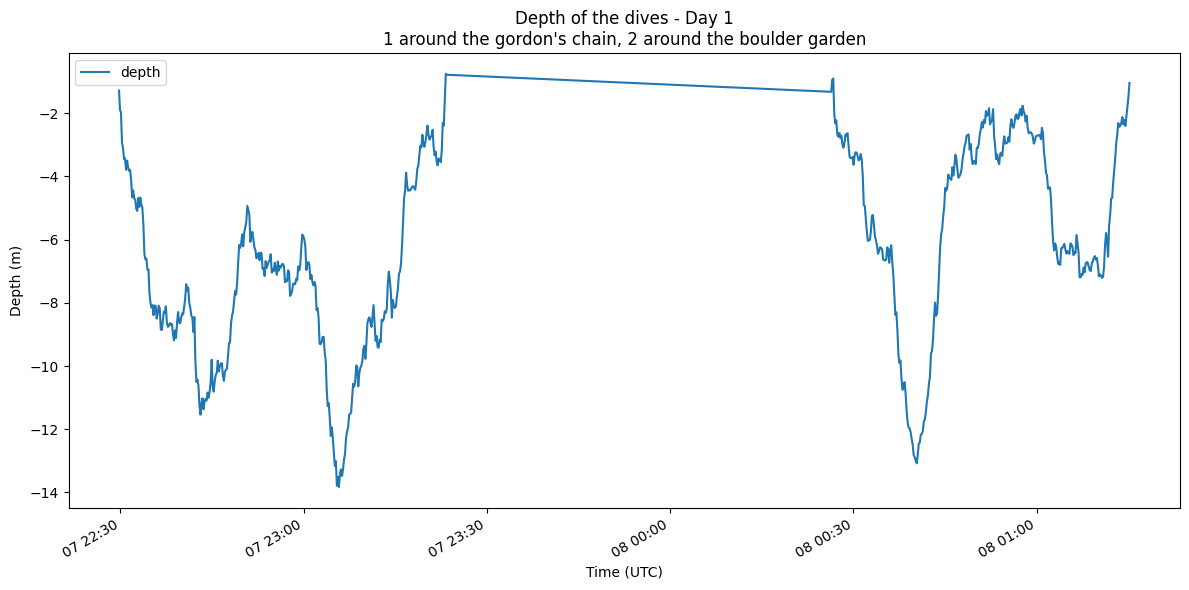

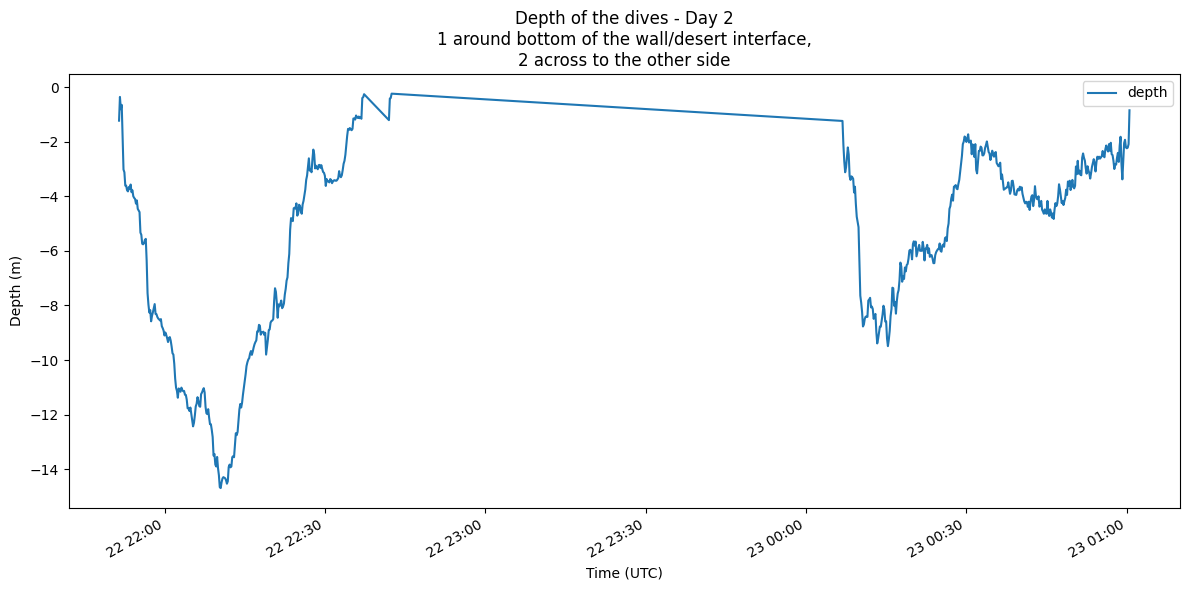

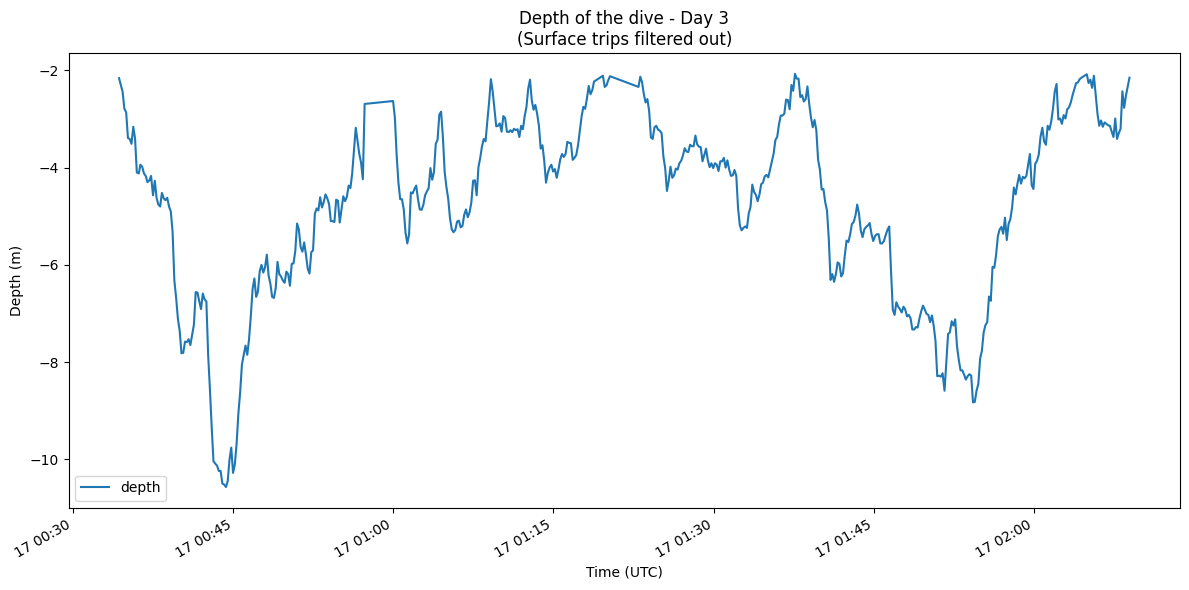

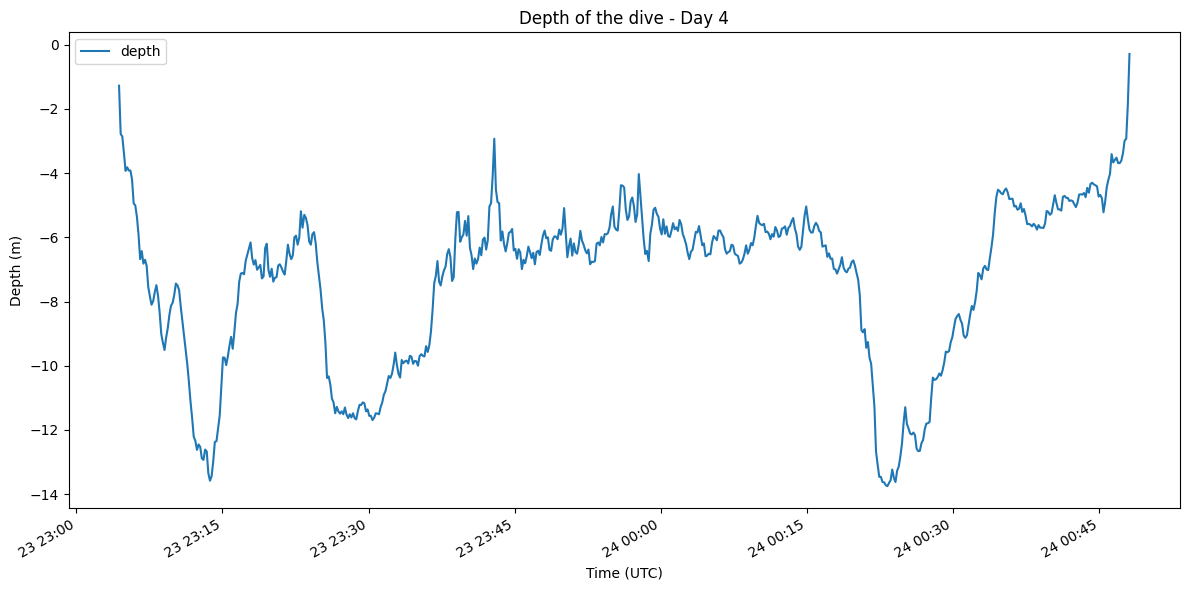

📊 Individual dive depth profiles displayed


In [5]:
# Show individual depth profiles (preserving the original analysis approach)
# Create subplots for each set of dives as in the original

# Depth profile for day 1: chain and boulder garden dives
depth_day_1 = depth_df[depth_df.source_file.str.contains("2024-03-08")]
if not depth_day_1.empty:
    depth_day_1.plot(
        y='depth', 
        figsize=(12, 6),
        title="Depth of the dives - Day 1\n1 around the gordon's chain, 2 around the boulder garden",
        ylabel="Depth (m)",
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

# Depth profile for day 2: wall to desert dives  
depth_day_2 = depth_df[depth_df.source_file.str.contains("2024-03-23")]
if not depth_day_2.empty:
    depth_day_2.plot(
        y='depth',
        figsize=(12, 6), 
        title="Depth of the dives - Day 2\n1 around bottom of the wall/desert interface,\n2 across to the other side",
        ylabel="Depth (m)",
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

# Day 3: Random swim (with surface trips filtered out)
depth_day_3 = depth_df[depth_df.source_file.str.contains("2024-05-17")]
if not depth_day_3.empty:
    # I got a bit disorientated and seasick, and I got my fin strap entangled on the
    # float line, so there's a couple of trips to the surface. So that they don't
    # get treated like high spots, I'm going to crop off any readings shallower than 2m.
    filtered_depth_3 = depth_day_3[depth_day_3.depth < -2]
    filtered_depth_3.plot(
        y='depth',
        figsize=(12, 6),
        title="Depth of the dive - Day 3\n(Surface trips filtered out)",
        ylabel="Depth (m)", 
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

# Day 4: Bommie dive
depth_day_4 = depth_df[depth_df.source_file.str.contains("2024-05-24")]
if not depth_day_4.empty:
    depth_day_4.plot(
        y='depth',
        figsize=(12, 6),
        title="Depth of the dive - Day 4",
        ylabel="Depth (m)",
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

print("📊 Individual dive depth profiles displayed")

## GPS Track Analysis

The GPS data comes from an app on my phone. This odd shape is because I forgot to turn it off and then we drove back to the shop. If we look at the numbers on the x axis, we've almost gone 0.1 of a degree, which in metric is:

```
Decimal Places   Aprox. Distance    Say What?
1                10 kilometers      6.2 miles
2                1 kilometer        0.62 miles
3                100 meters         About 328 feet
4                10 meters          About 33 feet
5                1 meter            About 3 feet
6                10 centimeters     About 4 inches
7                1.0 centimeter     About 1/2 an inch
8                1.0 millimeter     The width of paperclip wire.
9                0.1 millimeter     The width of a strand of hair.
10               10 microns         A speck of pollen.
11               1.0 micron         A piece of cigarette smoke.
12               0.1 micron         You're doing virus-level mapping at this point.
13               10 nanometers      Does it matter how big this is?
14               1.0 nanometer      Your fingernail grows about this far in one second.
15               0.1 nanometer      An atom. An atom! What are you mapping?
```

from [here](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)

But we don't care about driving around the Eastern Suburbs, so we'll have to crop it off. Also, this is both dives, so we'll need to split those out too.

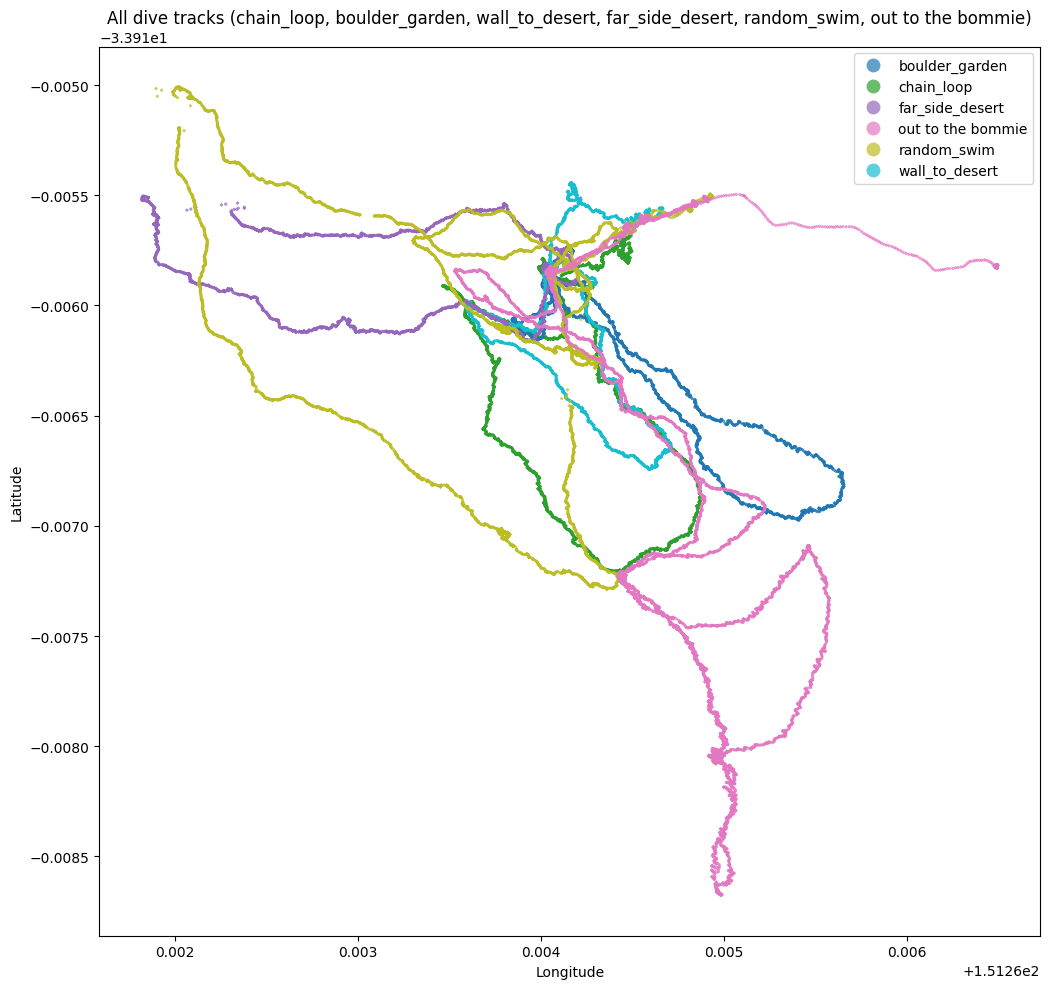

In [6]:
# Visualize all dive tracks (now handled cleanly by our data loader)
fig, ax = plt.subplots(figsize=(15, 10))
dives_gdf.plot(column="description", ax=ax, legend=True, alpha=0.7, markersize=2, marker="x")
ax.set_title(f"All dive tracks ({', '.join(dives_gdf.description.unique())})")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


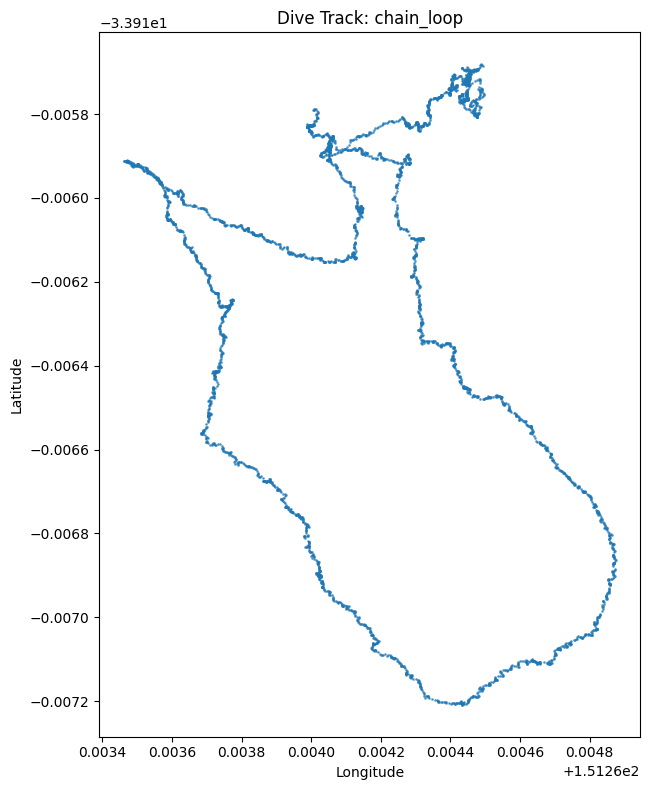

📍 chain_loop: 4200 GPS points


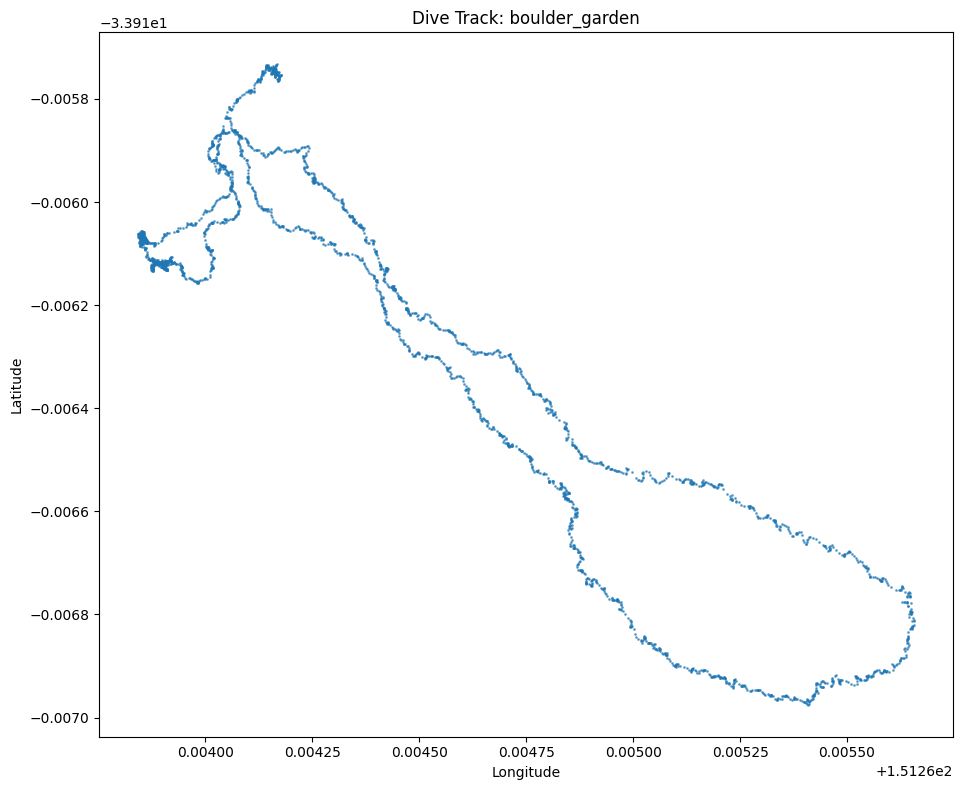

📍 boulder_garden: 3000 GPS points


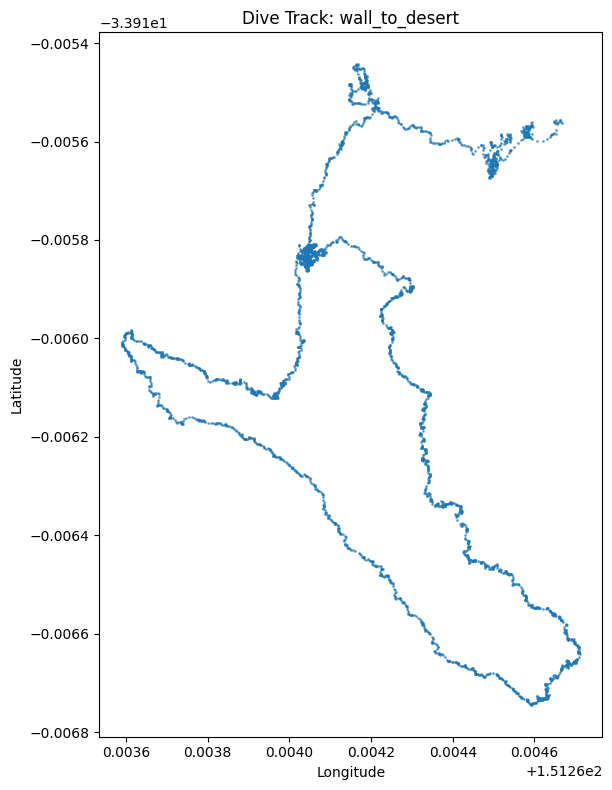

📍 wall_to_desert: 3598 GPS points


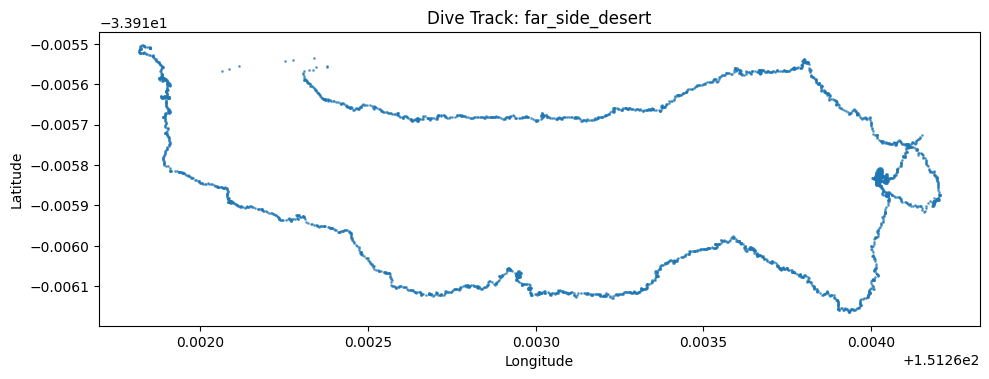

📍 far_side_desert: 3476 GPS points


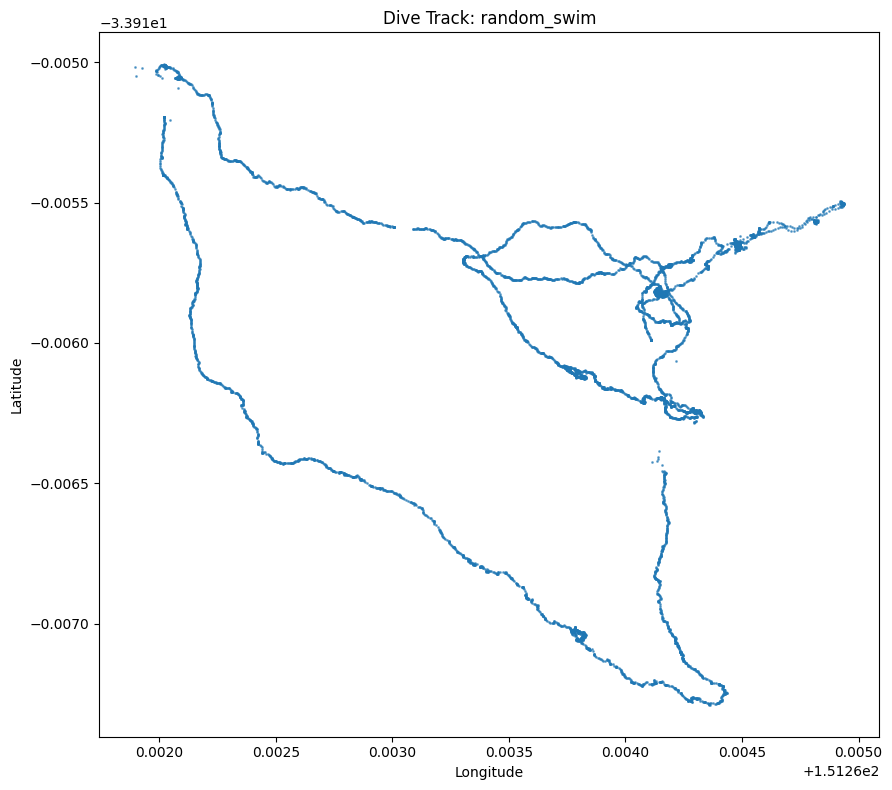

📍 random_swim: 8024 GPS points


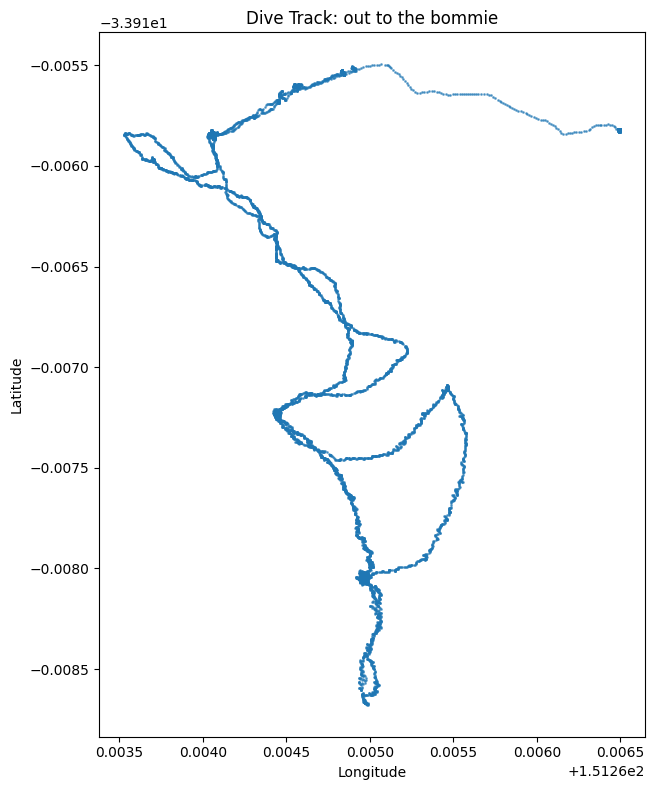

📍 out to the bommie: 9507 GPS points


In [7]:
# Show individual dive tracks as in original
for desc in dives_gdf.description.unique():
    track_data = dives_gdf[dives_gdf.description == desc]
    if not track_data.empty:
        fig, ax = plt.subplots(figsize=(10, 8))
        track_data.plot(ax=ax, alpha=0.6, markersize=1)
        ax.set_title(f"Dive Track: {desc}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        plt.tight_layout()
        plt.show()
        print(f"📍 {desc}: {len(track_data)} GPS points")

## Photo Data Integration

The glue that joins it all up is photos - the photos tell us when we were at a feature. And in this case, what the bottom condition was like.

In [8]:
# Timezone unification and data integration
# There are some tricky bits because everything is in different time zones, so let's unify them all into UTC
print("Before timezone conversion:")
print(f"\tdives_df: {repr(dives_gdf.iloc[0].name)}")
print(f"\tdepth_df: {repr(depth_df.iloc[0].name)}")  
print(f"\tphoto_df: {repr(photo_df.iloc[0].name)}")

# Convert all timestamps to UTC (the data loader should handle this, but ensuring consistency)
dives_gdf.index = dives_gdf.index.tz_convert("UTC")
depth_df.index = depth_df.index.tz_convert("UTC")  
photo_df.index = photo_df.index.tz_convert("UTC")

print("\nAfter timezone conversion:")
print(f"\tdives_df: {repr(dives_gdf.iloc[0].name)}")
print(f"\tdepth_df: {repr(depth_df.iloc[0].name)}")
print(f"\tphoto_df: {repr(photo_df.iloc[0].name)}")

# Add source identifiers
dives_gdf["source"] = "dives" 
depth_df["source"] = "depth"
photo_df["source"] = "photo"

Before timezone conversion:
	dives_df: Timestamp('2024-03-07 22:15:27+0000', tz='SimpleTZ('Z')')
	depth_df: Timestamp('2024-03-07 22:29:46+0000', tz='UTC')
	photo_df: Timestamp('2024-03-07 22:33:46+0000', tz='tzutc()')

After timezone conversion:
	dives_df: Timestamp('2024-03-07 22:15:27+0000', tz='UTC')
	depth_df: Timestamp('2024-03-07 22:29:46+0000', tz='UTC')
	photo_df: Timestamp('2024-03-07 22:33:46+0000', tz='UTC')


## Data Consolidation

If for some reason the data is too heavy, use this to chop it down. It's not doing any chopping at the moment.

The DataFrame below is from mixing all the data together. There are a lot more GPS signals than anything else, and a lot more depth values than photos. They're all time sorted, and then the preceding value is filled down until there's another one to take over.

In [9]:
# Consolidate all data sources
reduced_dives = dives_gdf.copy()
# reduced_dives = reduced_dives.iloc[::60]  # pick one frame a minute
# reduced_dives = reduced_dives[
#     reduced_dives.index > depth_df.index[0]
# ]  # wait until there's depth data

all_df = pd.concat([reduced_dives, depth_df, photo_df])
all_df.sort_index(axis=0, inplace=True)

# Forward fill to propagate values between sparse measurements
all_df["depth"] = all_df["depth"].ffill()
all_df["depth"] = all_df["depth"].fillna(0)
all_df["filename"] = all_df["filename"].ffill(limit=10)

# Use our refactored naive_ffill function for geometry
naieve_ffill(all_df, "geometry")

all_df["description"] = all_df["description"].ffill()
all_df.drop(["lat", "lon"], axis=1, inplace=True, errors="ignore")

# Convert to GeoDataFrame
all_gdf = gp.GeoDataFrame(all_df)

print(f"📊 Consolidated dataset: {len(all_gdf):,} total records")
print(f"   • Sources: {', '.join(all_gdf.source.value_counts().to_string().split())}")
all_gdf.head()

📊 Consolidated dataset: 34,514 total records
   • Sources: source, dives, 31805, depth, 2414, photo, 295


,description,geometry,source,depth,source_file,datetime,filename,marker_type,marker_number,bottom_condition,chain_vertex,note
dt,,,,,,,,,,,,
2024-03-07 22:15:27+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:28+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:29+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:30+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:31+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
all_gdf.marker_number.value_counts()

marker_number
        242
6         5
8         3
14        3
13        3
23        3
20        3
12        2
25        2
22        2
21        2
16        2
19        2
10        2
5         2
18        2
11        1
9         1
10.1      1
4         1
5.1       1
6.1       1
7         1
15        1
17        1
3         1
23.1      1
23.2      1
24        1
1         1
2         1
Name: count, dtype: int64

In [11]:
# Process markers (numbered buoys and intermediate points)
markers_df = all_gdf[
    (all_gdf.source == "photo")
    & ((all_gdf.marker_type == "numbered") | (all_gdf.marker_number != ""))
].copy()

intermediate_df = all_gdf[
    (all_gdf.source == "photo") & (all_gdf.marker_type == "intermediate")
].copy()

# Use our refactored marker text function
markers_df.loc[:, "marker_text"] = markers_df.apply(make_marker_text, axis=1)

# Create unified marker positions by grouping photos of the same marker
def get_centroid_geometry(grp):
    """Get centroid geometry, handling single vs multiple points properly"""
    if len(grp) == 1:
        # Single point - return it directly
        return grp.geometry.iloc[0]
    else:
        # Multiple points - calculate centroid manually
        coords = [(pt.x, pt.y) for pt in grp.geometry]
        centroid_x = sum(x for x, y in coords) / len(coords)
        centroid_y = sum(y for x, y in coords) / len(coords)
        from shapely.geometry import Point
        return Point(centroid_x, centroid_y)

uni_marker_df = (
    markers_df.groupby("marker_number")
    .apply(
        lambda grp: pd.Series(
            {
                "geometry": get_centroid_geometry(grp),
                "marker_text": grp.marker_text.iloc[0],
                "depth": grp.depth.mean(),
            }
        )
    )
    .sort_index()
)

print(f"🎯 Processed markers:")
print(f"   • {len(uni_marker_df)} numbered markers")
print(f"   • {len(intermediate_df)} intermediate markers")
uni_marker_df

🎯 Processed markers:
   • 30 numbered markers
   • 67 intermediate markers


C:\Users\bdoherty\AppData\Local\Temp\ipykernel_15492\3377265478.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,geometry,marker_text,depth
marker_number,,,
1.0,POINT (151.2645 -33.91566),1,-0.240000
2.0,POINT (151.26428 -33.9157),2,-2.150000
3.0,POINT (151.26402 -33.91589),3,-4.460000
4.0,POINT (151.26414 -33.91602),4,-5.510000
5.0,POINT (151.26412 -33.91614),5,-8.075000
5.1,POINT (151.26404 -33.91615),,-8.320000
6.0,POINT (151.26362 -33.916),6,-8.972000
6.1,POINT (151.26358 -33.91604),,-11.130000
7.0,POINT (151.26376 -33.91626),7,-9.280000


In [12]:
# CANONICAL MARKER ASSIGNMENT - FIXED VERSION
# This replaces the problematic cell above with working manual centroid calculation

import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

print("🏷️  Canonical marker assignment - FIXED VERSION")

# Work with the existing all_gdf
working_gdf = all_gdf.copy()

# 1. Ensure marker_number numeric (coerce invalid to NaN)
working_gdf['marker_number'] = pd.to_numeric(working_gdf.get('marker_number', None), errors='coerce')

# 2. Project to meters for distance calculations
working_gdf_m = working_gdf.to_crs(epsg=32756)

# 3. Add canonical columns
if 'canonical_marker_number' not in working_gdf.columns:
    working_gdf['canonical_marker_number'] = pd.Series([pd.NA]*len(working_gdf), dtype='Int64')
if 'canonical_marker' not in working_gdf.columns:
    working_gdf['canonical_marker'] = False

# 4. Find integer marker numbers
marker_nums = working_gdf['marker_number'].dropna()
int_numbers = sorted(marker_nums[marker_nums == np.floor(marker_nums)].unique())

# 5. Process each marker group
canonical_indices = []
for num in int_numbers:
    grp_idx = working_gdf.index[working_gdf['marker_number'] == num]
    if len(grp_idx) == 0:
        continue
        
    grp_proj = working_gdf_m.loc[grp_idx]
    if grp_proj.empty:
        continue
    
    # FIXED: Handle single vs multiple points properly
    if len(grp_proj) == 1:
        # Single point - just use it
        chosen_idx = grp_proj.index[0]
    else:
        # Multiple points - manual centroid calculation
        coords = [(pt.x, pt.y) for pt in grp_proj.geometry]
        centroid_x = sum(x for x, y in coords) / len(coords)
        centroid_y = sum(y for x, y in coords) / len(coords)
        centroid_geom = Point(centroid_x, centroid_y)
        dists = grp_proj.geometry.distance(centroid_geom)
        chosen_idx = dists.idxmin()
    
    canonical_indices.append(chosen_idx)

# 6. Apply canonical flags
canonical_indices = list(dict.fromkeys(canonical_indices))
working_gdf['canonical_marker_number'] = pd.Series([pd.NA]*len(working_gdf), dtype='Int64')
working_gdf['canonical_marker'] = False

if canonical_indices:
    subset_nums = working_gdf.loc[canonical_indices, 'marker_number']
    subset_int = subset_nums.apply(lambda v: int(v) if pd.notnull(v) else pd.NA)
    working_gdf.loc[canonical_indices, 'canonical_marker_number'] = subset_int.astype('Int64')
    working_gdf.loc[canonical_indices, 'canonical_marker'] = True
    working_gdf.loc[canonical_indices, 'marker_text'] = working_gdf.loc[canonical_indices, 'canonical_marker_number'].astype(str)

# Update main dataset
all_gdf = working_gdf.copy()

all_gdf.head()

🏷️  Canonical marker assignment - FIXED VERSION


,description,geometry,source,depth,source_file,datetime,filename,marker_type,marker_number,bottom_condition,chain_vertex,note,canonical_marker_number,canonical_marker,marker_text
dt,,,,,,,,,,,,,,,
2024-03-07 22:15:27+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,False,NaN
2024-03-07 22:15:28+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,False,NaN
2024-03-07 22:15:29+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,False,NaN
2024-03-07 22:15:30+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,False,NaN
2024-03-07 22:15:31+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,False,NaN


In [13]:
# Validation: reproduce marker summary table (canonical + intermediate/fractional)
cols = ['marker_number', 'geometry', 'marker_text', 'depth']
existing = [c for c in cols if c in all_gdf.columns]
validation_df = (
    all_gdf.loc[all_gdf['marker_number'].notna(), existing]
    .copy()
    .sort_values('marker_number')
)
# Display first 50 (adjust as needed)
print(f"Total marker-numbered rows (including fractional): {len(validation_df)}")
validation_df.head(60)

Total marker-numbered rows (including fractional): 53


,marker_number,geometry,marker_text,depth
dt,,,,
2024-03-22 22:43:49+00:00,1.0,POINT (151.2645 -33.91566),1,-0.24
2024-05-17 02:12:36+00:00,2.0,POINT (151.26428 -33.9157),2,-2.15
2024-03-22 21:55:03+00:00,3.0,POINT (151.26402 -33.91589),3,-4.46
2024-03-07 22:33:52+00:00,4.0,POINT (151.26414 -33.91602),4,-5.51
2024-03-07 22:35:08+00:00,5.0,POINT (151.26413 -33.91614),NaN,-8.15
2024-03-07 22:34:56+00:00,5.0,POINT (151.26412 -33.91614),5,-8.00
2024-03-07 22:36:07+00:00,5.1,POINT (151.26404 -33.91615),NaN,-8.32
2024-03-07 22:39:54+00:00,6.0,POINT (151.26363 -33.91601),NaN,-8.65
2024-03-22 22:02:48+00:00,6.0,POINT (151.2636 -33.91603),NaN,-11.04


# Confidence

This plot bins the reported depths by butting them into a 2m grid. We could go finer, but that's probably overkill.

It is coloured by the difference between the minimum depth and the maximum depth of points in that grid square. Given that the map is relatively flat, in any given square we shouldn't see much depth variation across 2m except for the transition of the wall. Anything over about 2m (45° across the grid) is probably me surfacing without trimming out those points.

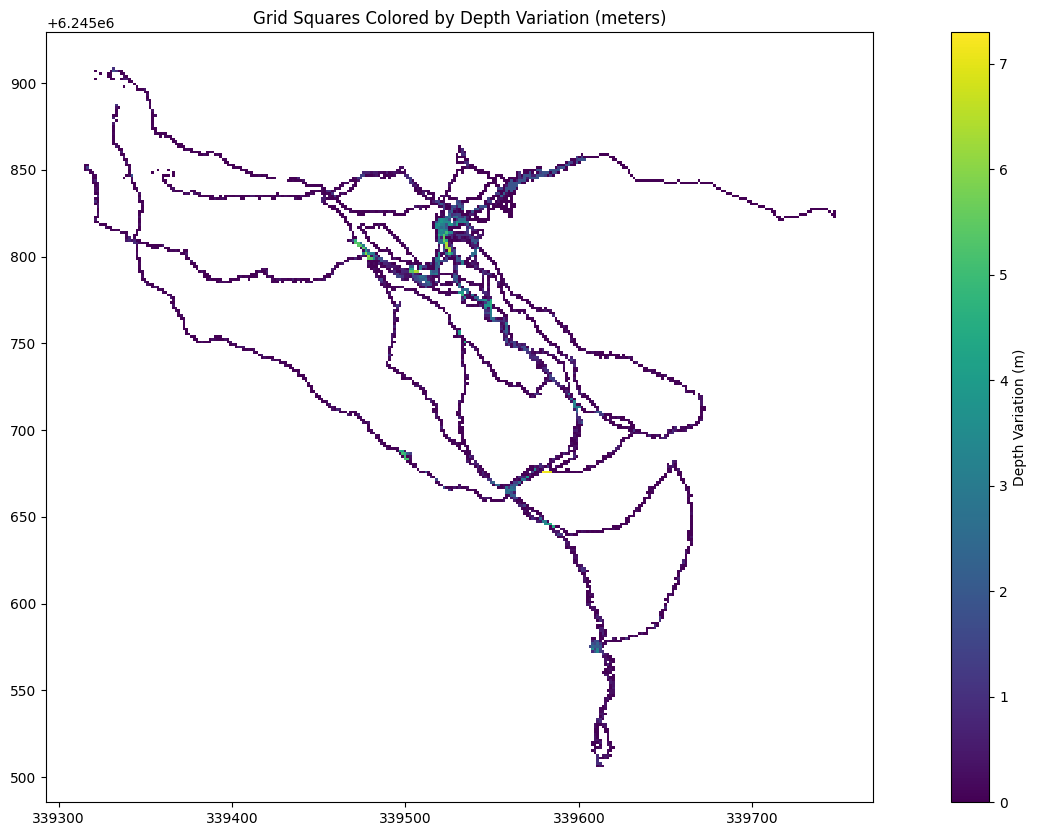

In [14]:
# Define grid in meters, assign points, compute depth variation, and plot
# Project points to a CRS in meters (e.g., UTM zone 56S for Sydney area)
all_gdf_m = all_gdf.to_crs(epsg=32756)

# Define grid size in meters
grid_size = 1.5  # Xm x Xm squares

# Get bounds
minx, miny, maxx, maxy = all_gdf_m.total_bounds

# Create grid cells
x_coords = np.arange(minx, maxx + grid_size, grid_size)
y_coords = np.arange(miny, maxy + grid_size, grid_size)
grid_cells = []
for x in x_coords[:-1]:
    for y in y_coords[:-1]:
        grid_cells.append(box(x, y, x + grid_size, y + grid_size))
grid_m = gp.GeoDataFrame({'geometry': grid_cells}, crs=all_gdf_m.crs)

# Spatial join: assign each point to a grid square
joined = gp.sjoin(all_gdf_m, grid_m, how='left', predicate='within')

# Group by grid square and calculate depth variation
if 'depth' in joined.columns:
    depth_var = joined.groupby('index_right')['depth'].agg(['min', 'max'])
    depth_var['variation'] = depth_var['max'] - depth_var['min']
    # Merge variation back to grid
    grid_m['depth_var'] = depth_var['variation']
else:
    grid_m['depth_var'] = np.nan

# Plot the grid colored by depth variation
fig, ax = plt.subplots(figsize=(20, 10))
grid_m.plot(column='depth_var', ax=ax, cmap='viridis', edgecolor=None, legend=True,
            legend_kwds={'label': "Depth Variation (m)"})
# all_gdf_m.plot(ax=ax, color='red', markersize=0.5, alpha=0.1)
ax.set_title('Grid Squares Colored by Depth Variation (meters)')
plt.show()

In [15]:
# Filtering points per grid, preserving canonical markers and bottom_condition
# Assumes 'joined' GeoDataFrame with depth and canonical marker columns is prepared.

chaotic_grid_count = 0
filtered_points = []

# Helper to transfer canonical marker metadata (and bottom_condition) from a removed canonical row
# to the retained deepest row when necessary.

def _transfer_canonical_marker(original_group: gpd.GeoDataFrame, kept_row: gpd.GeoDataFrame):
    if 'canonical_marker' not in original_group.columns:
        return kept_row

    canonical_rows = original_group[original_group['canonical_marker'] == True]
    if canonical_rows.empty:
        return kept_row

    kept_is_canonical = False
    if 'canonical_marker' in kept_row.columns:
        try:
            kept_is_canonical = bool(kept_row['canonical_marker'].iloc[0])
        except Exception:
            kept_is_canonical = False
    if kept_is_canonical:
        return kept_row

    source_row = canonical_rows.iloc[0]

    for col in ['marker_type', 'marker_number', 'canonical_marker_number', 'marker_text']:
        if col in source_row.index:
            if col in kept_row.columns:
                kept_row.at[kept_row.index[0], col] = source_row[col]
            else:
                kept_row[col] = source_row[col]

    kept_row.at[kept_row.index[0], 'canonical_marker'] = True

    if 'bottom_condition' in original_group.columns:
        existing_val = kept_row['bottom_condition'].iloc[0] if 'bottom_condition' in kept_row.columns else pd.NA
        if pd.isna(existing_val) or existing_val in (None, ''):
            bc_vals = []
            for v in canonical_rows['bottom_condition'].tolist():
                if pd.isna(v):
                    continue
                if v in (None, ''):
                    continue
                bc_vals.append(v)
            if bc_vals:
                if 'bottom_condition' in kept_row.columns:
                    kept_row.at[kept_row.index[0], 'bottom_condition'] = bc_vals[0]
                else:
                    kept_row['bottom_condition'] = bc_vals[0]

    return kept_row

for idx, group in joined.groupby('index_right'):
    if group.empty:
        continue
    depth_span = group['depth'].max() - group['depth'].min()

    if depth_span > 2:
        chaotic_grid_count += 1
        deepest = group.loc[[group['depth'].idxmin()]].copy()
        deepest = _transfer_canonical_marker(group, deepest)
        filtered_points.append(deepest)
    else:
        filtered_points.append(group)

filtered_points_gdf = gpd.GeoDataFrame(pd.concat(filtered_points, ignore_index=True), crs=joined.crs)

canonical_retained = int(filtered_points_gdf.get('canonical_marker', pd.Series(dtype=bool)).sum())
print(f"simplified {chaotic_grid_count} chaotic grids")
print(f"unfiltered points: {len(joined):,}, filtered points: {len(filtered_points_gdf):,}")
print(f"canonical markers retained: {canonical_retained}")

simplified 233 chaotic grids
unfiltered points: 34,514, filtered points: 27,919
canonical markers retained: 44


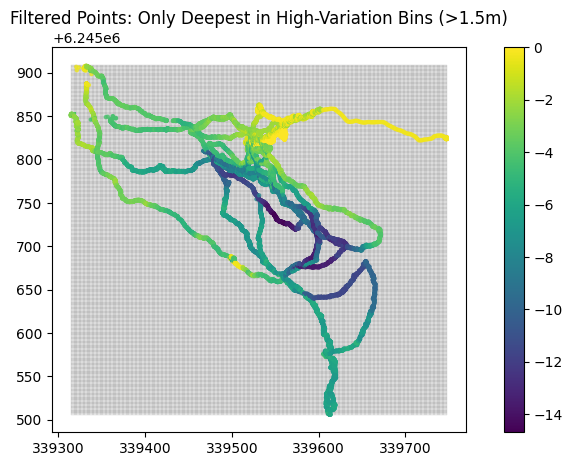

In [16]:
# Plot to verify
fig, ax = plt.subplots(figsize=(10, 5))
grid_m.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.1)
filtered_points_gdf.plot(ax=ax, markersize=5, alpha=0.7, column='depth', cmap='viridis', legend=True)
# all_gdf_m.plot(ax=ax, color='red', markersize=2, alpha=0.3)
ax.set_title(f'Filtered Points: Only Deepest in High-Variation Bins (>{grid_size}m)')
plt.show()

In [17]:
# Apply colors using the config
all_gdf["colour"] = all_gdf["bottom_condition"].apply(
    lambda x: BOTTOM_CONDITION_COLORS.get(x, "deeppink")
)

In [18]:
# Process bottom conditions using refactored functions
bottom_gdf = all_gdf[
    (all_gdf.source == "photo") & (all_gdf.bottom_condition != "unspecified")
]
print(f"📊 Bottom condition points: {len(bottom_gdf):,}")
bottom_gdf.head()

📊 Bottom condition points: 210


,description,geometry,source,depth,source_file,datetime,filename,marker_type,marker_number,bottom_condition,chain_vertex,note,canonical_marker_number,canonical_marker,marker_text,colour
dt,,,,,,,,,,,,,,,,
2024-03-07 22:33:46+00:00,chain_loop,POINT (151.26414 -33.91603),photo,-5.51,NaN,2024-03-08 09:33:46,GOPR0098.JPG,intermediate,NaN,kelp,NaN,NaN,<NA>,False,NaN,seagreen
2024-03-07 22:34:56+00:00,chain_loop,POINT (151.26412 -33.91614),photo,-8.00,NaN,2024-03-08 09:34:56,GOPR0102.JPG,numbered,5.0,rocky,True,NaN,5,True,5,gray
2024-03-07 22:35:19+00:00,chain_loop,POINT (151.26412 -33.91613),photo,-8.07,NaN,2024-03-08 09:35:19,GOPR0104.JPG,,NaN,rocky,NaN,NaN,<NA>,False,NaN,gray
2024-03-07 22:35:54+00:00,chain_loop,POINT (151.26406 -33.91615),photo,-8.10,NaN,2024-03-08 09:35:54,GOPR0105.JPG,,NaN,rocky,NaN,NaN,<NA>,False,NaN,gray
2024-03-07 22:36:07+00:00,chain_loop,POINT (151.26404 -33.91615),photo,-8.32,NaN,2024-03-08 09:36:07,GOPR0106.JPG,intermediate,5.1,rocky,True,NaN,<NA>,False,NaN,gray


In [19]:
# A-SERIES PAPER BOUNDS ADJUSTMENT
# Function to adjust map bounds to match A-series paper aspect ratios
def a_paper_padding(bounds, orientation="landscape"):
    """
    Adjust geographic bounds to match A-series paper aspect ratios for printing.

    Parameters:
    -----------
    bounds : tuple
        (minx, miny, maxx, maxy) - original geographic bounds
    orientation : str
        'landscape' or 'portrait'

    Returns:
    --------
    tuple : (minx, miny, maxx, maxy) - adjusted bounds with paper aspect ratio
    """

    # A-series paper aspect ratios (width:height for portrait)
    # A-series ratio is 1:√2 ≈ 1:1.414
    paper_ratio = math.sqrt(2)

    # For landscape, flip the ratio (width > height)
    if orientation == "landscape":
        target_ratio = paper_ratio  # width/height for landscape
    else:
        target_ratio = 1 / paper_ratio  # width/height for portrait

    # Get original bounds
    minx, miny, maxx, maxy = bounds

    # Calculate current dimensions
    current_width = maxx - minx
    current_height = maxy - miny
    current_ratio = current_width / current_height

    # Calculate center point
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    print(f"📐 PAPER BOUNDS ADJUSTMENT")
    print(
        f"   Original: {current_width:.6f} × {current_height:.6f} ratio: {current_ratio:.3f}   Target ratio {target_ratio:.3f}"
    )

    # Adjust bounds to match target ratio
    if current_ratio > target_ratio:
        # Current bounds are too wide, need to increase height
        new_width = current_width
        new_height = current_width / target_ratio
    else:
        # Current bounds are too tall, need to increase width
        new_height = current_height
        new_width = current_height * target_ratio

    # Calculate new bounds centered on the original center
    new_minx = center_x - new_width / 2
    new_maxx = center_x + new_width / 2
    new_miny = center_y - new_height / 2
    new_maxy = center_y + new_height / 2

    new_bounds = (new_minx, new_miny, new_maxx, new_maxy)

    print(
        f"   Adjusted: {new_width:.6f} × {new_height:.6f} (ratio: {new_width/new_height:.3f})"
    )
    print(
        f"   Context gained: {((new_width * new_height) / (current_width * current_height) - 1) * 100:.1f}% more area"
    )

    return new_bounds


# Example usage demonstration
print("🖨️  A-SERIES PAPER BOUNDS FUNCTION READY")
print("=" * 50)
print("Usage examples:")
print("  bounds = a_paper_padding(current_bounds)")
print("  bounds = a_paper_padding(current_bounds, = 'landscape')")
print(
    "  bounds = a_paper_padding(MultiPoint(all_gdf.geometry).envelope.buffer(0.0003).bounds)"
)
print()

# Test with current map bounds if available
if "all_gdf" in globals():
    print("🧪 Testing with current dive data:")
    buffer_radius = 0.0003
    test_bounds = all_gdf.total_bounds
    # Apply buffer to the bounds instead
    buffer_radius = 0.0003
    minx, miny, maxx, maxy = test_bounds
    buffered_bounds = (minx - buffer_radius, miny - buffer_radius, 
                    maxx + buffer_radius, maxy + buffer_radius)
    test_bounds = buffered_bounds
    a3_bounds = a_paper_padding(test_bounds, "landscape")
    print(f"✅ A3 landscape bounds: {a3_bounds}")
else:
    print("ℹ️  Run data loading cells first to test with actual dive data")

🖨️  A-SERIES PAPER BOUNDS FUNCTION READY
Usage examples:
  bounds = a_paper_padding(current_bounds)
  bounds = a_paper_padding(current_bounds, = 'landscape')
  bounds = a_paper_padding(MultiPoint(all_gdf.geometry).envelope.buffer(0.0003).bounds)

🧪 Testing with current dive data:
📐 PAPER BOUNDS ADJUSTMENT
   Original: 0.005279 × 0.004268 ratio: 1.237   Target ratio 1.414
   Adjusted: 0.006036 × 0.004268 (ratio: 1.414)
   Context gained: 14.4% more area
✅ A3 landscape bounds: (np.float64(151.26113885334414), np.float64(-33.918976670000006), np.float64(151.2671752966559), np.float64(-33.91470826))


In [ ]:
print("🗺️  Starting map generation...")
# Create map renderer and initialize figure
map_renderer = MapRenderer((30, 30 * math.sqrt(2)))
fig, ax = map_renderer.create_figure()

# Calculate bounds and set limits
buffer_radius = 0.00035
# Use total_bounds instead of MultiPoint constructor
base_bounds = all_gdf.total_bounds
minx, miny, maxx, maxy = base_bounds
buffered_bounds = (minx - buffer_radius, miny - buffer_radius, 
                  maxx + buffer_radius, maxy + buffer_radius)
bounds = a_paper_padding(buffered_bounds)

# Create invisible points at each corner to force the geographic extent
corner_points = [
    (bounds[0], bounds[1]),  # bottom-left
    (bounds[0], bounds[3]),  # top-left
    (bounds[2], bounds[1]),  # bottom-right
    (bounds[2], bounds[3])   # top-right
]
# Plot them with alpha=0 (invisible) just to establish the extent
ax.scatter(*zip(*corner_points), alpha=0, s=0.1)


# Add scalebar using the modular approach
starting_point = geopy_pt(-33.9175, 151.265)
scalebar_distances = [0, 5, 10, 15, 20, 50, 100]
map_renderer.add_scalebar(starting_point, scalebar_distances)

# Add north arrow using the modular approach
n_bottom_pt = geopy_pt(-33.9175, 151.267)
map_renderer.add_north_arrow(n_bottom_pt)

# Add colorbar for depth
divider = make_axes_locatable(ax)
cax_cb = divider.append_axes("right", size="2%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=plt.Normalize(vmin=-14, vmax=0))
cbar = plt.colorbar(sm, cax=cax_cb, label="Depth (m)")

# Load and add click conditions (shore data) - this is what was missing!

json_df = pd.read_json("click_conditions.json")
click_gdf = gp.GeoDataFrame(
    geometry=json_df.apply(lambda row: Point(row.lon, row.lat), axis=1)
)
click_gdf["bottom_condition"] = json_df.condition
click_gdf.set_crs(all_gdf.crs, inplace=True)

# Concatenate with filtered photo data
all_gdf = pd.concat([all_gdf, click_gdf], ignore_index=True)
print("📍 Added click conditions (shore data)")

# Plot bottom condition markers
add_bottom_conditions = False
if add_bottom_conditions:
    bottom_gdf = all_gdf[all_gdf.bottom_condition.notnull()]
    bottom_gdf.plot(color=bottom_gdf.colour, ax=ax, markersize=1, alpha=0.8)
    print(f"🎨 Added {len(bottom_gdf)} bottom condition markers")

# Add contours using the modular renderer WITH SHORE CONDITIONS INTEGRATION
print("🔧 Preparing contour data with shore conditions...")

# Step 1: Get underwater depth data
underwater_contour_gdf = all_gdf[
    all_gdf.depth.notnull() & (all_gdf.depth < -1.5)
].copy()

# Step 2: Prepare shore conditions with depths
shore_conditions = list(SHORE_DEPTHS.keys())
shore_gdf = click_gdf[click_gdf.bottom_condition.isin(shore_conditions)].copy()
shore_gdf["depth"] = shore_gdf["bottom_condition"].map(SHORE_DEPTHS, na_action="ignore")

# Step 3: Concatenate shore and underwater data
contour_gdf = pd.concat([underwater_contour_gdf, shore_gdf], ignore_index=True)

print(
    f"✅ Contour data prepared: {len(contour_gdf)} records (depth range: {contour_gdf.depth.min():.1f}m to {contour_gdf.depth.max():.1f}m)"
)
print(f"   • Underwater records: {len(underwater_contour_gdf)}")
print(f"   • Shore condition records: {len(shore_gdf)}")

# Initialize contours variable for use by other cells
contours = None
contour_labels = None

if len(contour_gdf) > 0:
    try:
        contour_renderer = ContourRenderer()
        levels = list(range(-15, 0, 1))
        # Capture the contour object returned by the renderer
        contours = contour_renderer.plot_contours(ax, contour_gdf, levels, show_labels=False)
        # Add labels using a second call
        contour_labels = contour_renderer.plot_contours(
            ax,
            contour_gdf,
            levels,
            labels_only=True,
            number_size=9,
            label_color=TEXT_COLOUR,
        )
        print("📈 Generated depth contours WITH shore conditions")
        print(f"📊 Contours variable created with {len(contours.levels)} levels: {contours.levels}")
    except Exception as e:
        print(f"⚠️  Could not generate contours: {e}")

# Add satellite basemap using the map renderer
google_tiles = {
    "url": "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    "attribution": "Google Satellite",
    "name": "Google Satellite",
}
cx.add_basemap(
    ax,
    crs=all_gdf.crs,
    source=google_tiles["url"],
    attribution=google_tiles["attribution"],
    zoom=18,
)

# Add numbered markers using the modular marker renderer
marker_renderer = MarkerRenderer()
for _, row in uni_marker_df.iterrows():
    marker_renderer.add_numbered_marker(ax, row)
    marker_renderer.add_tolerance_circle(ax, row)

print(f"🎯 Added {len(uni_marker_df)} numbered markers with tolerance circles")

# Add notes if they exist
notes_gdf = all_gdf[all_gdf.note.notnull()]
if not notes_gdf.empty:
    for _, row in notes_gdf.iterrows():
        apply_annotations(pd.DataFrame([row]), ax, add_note_label)
    print(f"📝 Added {len(notes_gdf)} note annotations")

# Plot the chain trail line
chain_pts = uni_marker_df.geometry.copy()
chain_pts[26.0] = uni_marker_df.geometry[3.0]  # Add return path
chain_pts[27.0] = uni_marker_df.geometry[2.0]  # I haven't found marker 2 yet
chain_pts[28.0] = uni_marker_df.geometry[1.0]

chain_line_string = LineString(chain_pts)
chain_df = gp.GeoDataFrame(geometry=[chain_line_string])
chain_df.plot(ax=ax, linewidth=5, color="white")

# Calculate total length and add text
total_length = measure_line_string(chain_line_string)
ax.text(
    ScaleBarRenderer.move_point(geopy_pt(-33.9175, 151.265), 200, 0).longitude,
    geopy_pt(-33.9175, 151.265).latitude,
    f"The total length of the chain loop, from 1 back to 1, is {total_length:.0f} meters.",
    ha="left",
    fontsize=12,
    color=TEXT_COLOUR,
)
print(f"⛓️  Chain trail: {total_length:.0f}m total length")

# Add shortcut arrows
routes = [(23, 5), (11, 16), (5, 14)]
for from_marker, to_marker in routes:
    try:
        draw_shortcut_arrow(
            all_gdf,
            ax,
            from_marker_number=from_marker,
            to_marker_number=to_marker,
            text_colour=TEXT_COLOUR,
            arrow_colour=TEXT_COLOUR,
            text_size=9,
        )
    except Exception as e:
        print(
            f"⚠️  Could not add shortcut arrows from {from_marker} to {to_marker}: {e}"
        )
print("🧭 Added compass bearing shortcuts")


# Add spear fishing boundary line
spear_fishing_boundary = gp.GeoSeries(
    LineString(SPEAR_FISHING_BOUNDARY_COORDS), crs=all_gdf.crs
)
spear_fishing_boundary.plot(ax=ax, color="grey", linewidth=1, linestyle="--", alpha=0.8)
# ax.text(
#     SPEAR_FISHING_BOUNDARY_COORDS[0][0],
#     SPEAR_FISHING_BOUNDARY_COORDS[0][1] + 0.0001,
#     "Clovelly and Gordons Bay Spearfishing Closure this side of this line",
#     rotation=-19.84,
#     fontsize=9,
#     color="grey",
#     ha="left",
# )

# Create legend using the modular approach
legend_handles = marker_renderer.create_legend(ax, ncols=2)


# Finalize plot using the map renderer
map_renderer.finalize_plot(bounds, "Gordon's Bay Trail Map")

ax.set_aspect("equal")

# Save the map
plt.savefig("docs/marker_graph.png", transparent=True, dpi=300)
plt.savefig("docs/marker_graph_small.png", transparent=True, dpi=72)
plt.savefig("docs/marker_graph.svg", transparent=True)
plt.close()  # Keep performance optimized

print("🎉 Map generation complete!")
print("💾 Saved as marker_graph.png and .svg")
print(
    f"📐 Map bounds: x=[{bounds[0]:.6f}, {bounds[2]:.6f}], y=[{bounds[1]:.6f}, {bounds[3]:.6f}]"
)

🗺️  Starting map generation...


📐 PAPER BOUNDS ADJUSTMENT
   Original: 0.005379 × 0.004368 ratio: 1.231   Target ratio 1.414
   Adjusted: 0.006178 × 0.004368 (ratio: 1.414)
   Context gained: 14.9% more area
📍 Added click conditions (shore data)
🔧 Preparing contour data with shore conditions...
✅ Contour data prepared: 28594 records (depth range: -14.7m to 0.0m)
   • Underwater records: 28529
   • Shore condition records: 65
[DEBUG] Before contour generation: contours = <class 'NoneType'>
[DEBUG] Attempting contour generation with 28594 points...
[DEBUG] Calling plot_contours for main contours...
[VIZ DEBUG] plot_contours called with labels_only=False, show_labels=False
[VIZ DEBUG] Data shape: (28594, 16), levels: [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
[VIZ DEBUG] prep_contour_data called with 28594 points
📍 Added click conditions (shore data)
🔧 Preparing contour data with shore conditions...
✅ Contour data prepared: 28594 records (depth range: -14.7m to 0.0m)
   • Underwater records: 2852

# Export Depth Data

This exports depth data to CSV for further analysis or sharing.

In [21]:
# Export depth data using the consolidated all_gdf dataset
try:
    # Use the consolidated dive data that includes all depth, GPS, and photo data
    export_data = all_gdf.copy()
    
    # Select key columns for export (using actual available columns)
    depth_records = export_data[export_data.depth.notnull() & (export_data.depth != 0)].copy()
    
    # Prepare export columns
    if hasattr(depth_records, 'geometry'):
        # Extract lat/lon from geometry
        depth_records['latitude'] = depth_records.geometry.apply(lambda x: x.y if x else None)
        depth_records['longitude'] = depth_records.geometry.apply(lambda x: x.x if x else None)
    
    # Select relevant columns for export
    export_columns = ['latitude', 'longitude', 'depth', 'description']
    available_columns = [col for col in export_columns if col in depth_records.columns]
    export_df = depth_records[available_columns].dropna()
    
    # Export to CSV
    output_file = "depth.csv"
    export_df.to_csv(output_file, index=True)  # Include timestamp index
    
    print(f"✅ Exported {len(export_df)} depth records to {output_file}")
    print(f"📊 Columns: {list(export_df.columns)}")
    if len(export_df) > 0:
        print(f"📅 Date range: {export_df.index.min()} to {export_df.index.max()}")
        print(f"🌊 Depth range: {export_df['depth'].max():.1f}m to {export_df['depth'].min():.1f}m")
    
except Exception as e:
    print(f"⚠️  Error exporting depth data: {e}")
    print("Available columns:", all_gdf.columns.tolist())
    print("Data shape:", all_gdf.shape)

✅ Exported 33655 depth records to depth.csv
📊 Columns: ['latitude', 'longitude', 'depth', 'description']
📅 Date range: 859 to 34513
🌊 Depth range: -0.2m to -14.7m


# Interactive Folium Map

Create an interactive web map that can be saved as HTML.

In [26]:
# INTERACTIVE FOLIUM MAP - Updated for Refactored Data Model with DEBUG
print("🐛 DEBUG: Starting Folium map creation...")

# Create base map centered on Gordon's Bay using our consolidated data
print("🐛 DEBUG: Extracting coordinates from all_gdf...")

# Extract coordinates from the all_gdf geometry column
coords_data = all_gdf[all_gdf.geometry.notnull()].copy()
coords_data['latitude'] = coords_data.geometry.apply(lambda c: c.y if c else None)
coords_data['longitude'] = coords_data.geometry.apply(lambda c: c.x if c else None)

center_lat = coords_data['latitude'].mean()
center_lon = coords_data['longitude'].mean()

print(f"🐛 DEBUG: Center coordinates calculated - lat: {center_lat:.6f}, lon: {center_lon:.6f}")
print(f"🐛 DEBUG: Creating base folium map...")

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=17,
    tiles='CartoDB positron',  # Clean background for underwater features
    max_zoom=25,  # Allow extreme zoom levels
    min_zoom=1,   # Allow wide zoom out
    prefer_canvas=True  # Better performance for complex overlays
)

print("🐛 DEBUG: Base map created successfully")
print("🐛 DEBUG: Adding satellite imagery overlay...")

# Add satellite imagery overlay with extended zoom range
satellite = folium.raster_layers.WmsTileLayer(
    url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    layers='World_Imagery',
    name='Satellite',
    overlay=True,
    control=True,
    transparent=False,
    opacity=0.8,
    max_zoom=25,  # Allow tiles to pixelate rather than disappear
    min_zoom=1,   # Show tiles at all zoom levels
    bounds=None,  # No bounds restriction
    show=True     # Show by default
)
satellite.add_to(m)

# Add Google Satellite layer for better zoom behavior
try:
    google_satellite = folium.raster_layers.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite',
        name='Google Satellite (High Res)',
        overlay=True,
        control=True,
        max_zoom=25,  # Allow extreme pixelation
        min_zoom=1
    )
    google_satellite.add_to(m)
    print("🛰️  Added Google Satellite layer for better zoom persistence")
except Exception as e:
    print(f"⚠️  Could not add Google Satellite layer: {e}")

print(f"🐛 DEBUG: Processing GPS tracks - found {len(dives_gdf.description.unique())} unique descriptions")

# Add GPS tracks using our consolidated dive data - each dive track on its own layer
for i, desc in enumerate(dives_gdf.description.unique()):
    print(f"🐛 DEBUG: Processing GPS track {i+1}/{len(dives_gdf.description.unique())}: {desc}")
    
    track_data = dives_gdf[dives_gdf.description == desc]
    if not track_data.empty:
        # Create a feature group for this dive track
        track_layer = folium.FeatureGroup(name=f"🤿 GPS Track: {desc}", show=False)

        # Convert to list of [lat, lon] for folium
        track_coords = [[row.geometry.y, row.geometry.x] 
                       for _, row in track_data.iterrows() if row.geometry is not None]
        
        if track_coords:  # Only add if we have valid coordinates
            folium.PolyLine(
                locations=track_coords,
                color=TEXT_COLOUR,
                weight=2,
                opacity=0.8,
                popup=f"GPS Track: {desc}"
            ).add_to(track_layer)
            
        track_layer.add_to(m)
        print(f"🐛 DEBUG: Track {desc} added successfully")

print(f"📍 Added {len(dives_gdf.description.unique())} GPS dive tracks")

# Add spear fishing boundary on its own layer
boundaries_layer = folium.FeatureGroup(name="🎣 Spear Fishing Boundary")

folium.PolyLine(
    locations=[[coord.y, coord.x] for coord in SPEAR_FISHING_BOUNDARY_COORDS],  # Convert to [lat, lon]
    color='red',
    weight=3,
    opacity=0.8,
    popup="Spear Fishing Boundary"
).add_to(boundaries_layer)

boundaries_layer.add_to(m)

# Add the chain trail on its own layer (the most important feature!)
chain_trail_layer = folium.FeatureGroup(name="⛓️ Chain Trail")
if 'chain_line_string' in globals() and chain_line_string is not None:
    # Extract coordinates from the LineString geometry
    chain_coords = [[point[1], point[0]] for point in chain_line_string.coords]  # [lat, lon] for folium
    folium.PolyLine(
        locations=chain_coords,
        color='orange',
        weight=5,
        opacity=0.9,
        popup="Gordon's Bay Chain Trail - The main navigation route"
    ).add_to(chain_trail_layer)
    print(f"⛓️  Added chain trail with {len(chain_coords)} points")
else:
    print("⚠️  Chain trail not available - run the matplotlib map cell first")

chain_trail_layer.add_to(m)

# Add numbered chain markers on their own layer
chain_markers_layer = folium.FeatureGroup(name="🎯 Chain Markers")
if 'uni_marker_df' in globals() and not uni_marker_df.empty:
    chain_marker_count = 0
    for marker_num, row in uni_marker_df.iterrows():
        # Only show markers for whole numbers (not fractional direction changes)
        if float(marker_num).is_integer():
            lat, lon = row.geometry.y, row.geometry.x
            
            # Add the circular marker
            folium.CircleMarker(
                location=[lat, lon],
                radius=12,
                popup=folium.Popup(f"<b>Chain Marker {marker_num}</b><br>Depth: {row.depth:.1f}m", max_width=200),
                color='orange',
                fillColor='yellow',
                fillOpacity=0.8,
                weight=3
            ).add_to(chain_markers_layer)
            
            # Add the number as a text label using DivIcon
            folium.Marker(
                location=[lat, lon],
                icon=folium.DivIcon(
                    html=f'<div style="font-family: Arial; font-weight: bold; font-size: 14px; color: black; text-align: center; text-shadow: 1px 1px 2px white;">{int(marker_num)}</div>',
                    icon_size=(20, 20),
                    icon_anchor=(10, 10)
                )
            ).add_to(chain_markers_layer)
            chain_marker_count += 1
    print(f"🎯 Added {chain_marker_count} numbered chain markers with visible numbers")

chain_markers_layer.add_to(m)

# Add depth contour lines as a separate layer
if 'contours' in globals() and contours is not None:
    contour_layer = folium.FeatureGroup(name="🌊 Depth Contours", show=False)
    
    # Extract contour line coordinates from the matplotlib contours object
    contour_lines = {}
    for i, level in enumerate(contours.levels):
        level_segments = contours.allsegs[i]
        contour_lines[level] = level_segments
    
    # Color map for different depths
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    norm = colors.Normalize(vmin=-15, vmax=0)
    cmap = cm.get_cmap('rainbow')
    
    contour_count = 0
    for depth_level, segments in contour_lines.items():
        # Get color for this depth level
        depth_color = colors.to_hex(cmap(norm(depth_level)))
        
        for segment in segments:
            if len(segment) > 2:  # Only draw segments with sufficient points
                # Convert coordinates to [lat, lon] for folium
                coords = [[point[1], point[0]] for point in segment]  # Note: folium uses [lat, lon]
                
                folium.PolyLine(
                    locations=coords,
                    color=depth_color,
                    weight=2,
                    opacity=0.7,
                    popup=f"Depth: {depth_level}m"
                ).add_to(contour_layer)
                contour_count += 1
    
    contour_layer.add_to(m)
    print(f"🌊 Added {contour_count} depth contour segments across {len(contour_lines)} depth levels")
else:
    print("⚠️  No contours available - run the matplotlib map generation cell first")

# Add layer control
folium.LayerControl().add_to(m)

# Save interactive map
m.save('clickmap.html')

# Display the map in the notebook
# m

🐛 DEBUG: Starting Folium map creation...
🐛 DEBUG: Extracting coordinates from all_gdf...
🐛 DEBUG: Center coordinates calculated - lat: -33.916268, lon: 151.264162
🐛 DEBUG: Creating base folium map...
🐛 DEBUG: Base map created successfully
🐛 DEBUG: Adding satellite imagery overlay...
🛰️  Added Google Satellite layer for better zoom persistence
🐛 DEBUG: Processing GPS tracks - found 6 unique descriptions
🐛 DEBUG: Processing GPS track 1/6: chain_loop
🐛 DEBUG: Center coordinates calculated - lat: -33.916268, lon: 151.264162
🐛 DEBUG: Creating base folium map...
🐛 DEBUG: Base map created successfully
🐛 DEBUG: Adding satellite imagery overlay...
🛰️  Added Google Satellite layer for better zoom persistence
🐛 DEBUG: Processing GPS tracks - found 6 unique descriptions
🐛 DEBUG: Processing GPS track 1/6: chain_loop
🐛 DEBUG: Track chain_loop added successfully
🐛 DEBUG: Processing GPS track 2/6: boulder_garden
🐛 DEBUG: Track chain_loop added successfully
🐛 DEBUG: Processing GPS track 2/6: boulder_ga

C:\Users\bdoherty\AppData\Local\Temp\ipykernel_15492\3846701059.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow')


  -15.0m contour: 0 segments with lengths []
  -14.0m contour: 2 segments with lengths [5, 5]
  -13.0m contour: 4 segments with lengths [19, 5, 21, 5]
  -12.0m contour: 7 segments with lengths [66, 14, 6, 39, 43, 5, 5]
  -11.0m contour: 8 segments with lengths [99, 91, 11, 5, 5, 5, 7, 5]
  -10.0m contour: 4 segments with lengths [116, 99, 5, 29]
  -9.0m contour: 2 segments with lengths [138, 167]
  -8.0m contour: 2 segments with lengths [294, 5]
  -7.0m contour: 3 segments with lengths [270, 5, 5]
  -6.0m contour: 8 segments with lengths [284, 5, 5, 5, 5, 5, 15, 5]
  -5.0m contour: 9 segments with lengths [300, 5, 5, 7, 5, 7, 5, 5, 5]
  -4.0m contour: 3 segments with lengths [360, 7, 5]
  -3.0m contour: 3 segments with lengths [292, 75, 5]
  -2.0m contour: 10 segments with lengths [289, 4, 39, 7, 5, 5, 5, 5, 9, 5]
  -1.0m contour: 4 segments with lengths [190, 92, 11, 5]
🔧 Preprocessing 1m contour: combining 190 and 92 point segments
   Best connection: seg1_end to seg2_start (distance

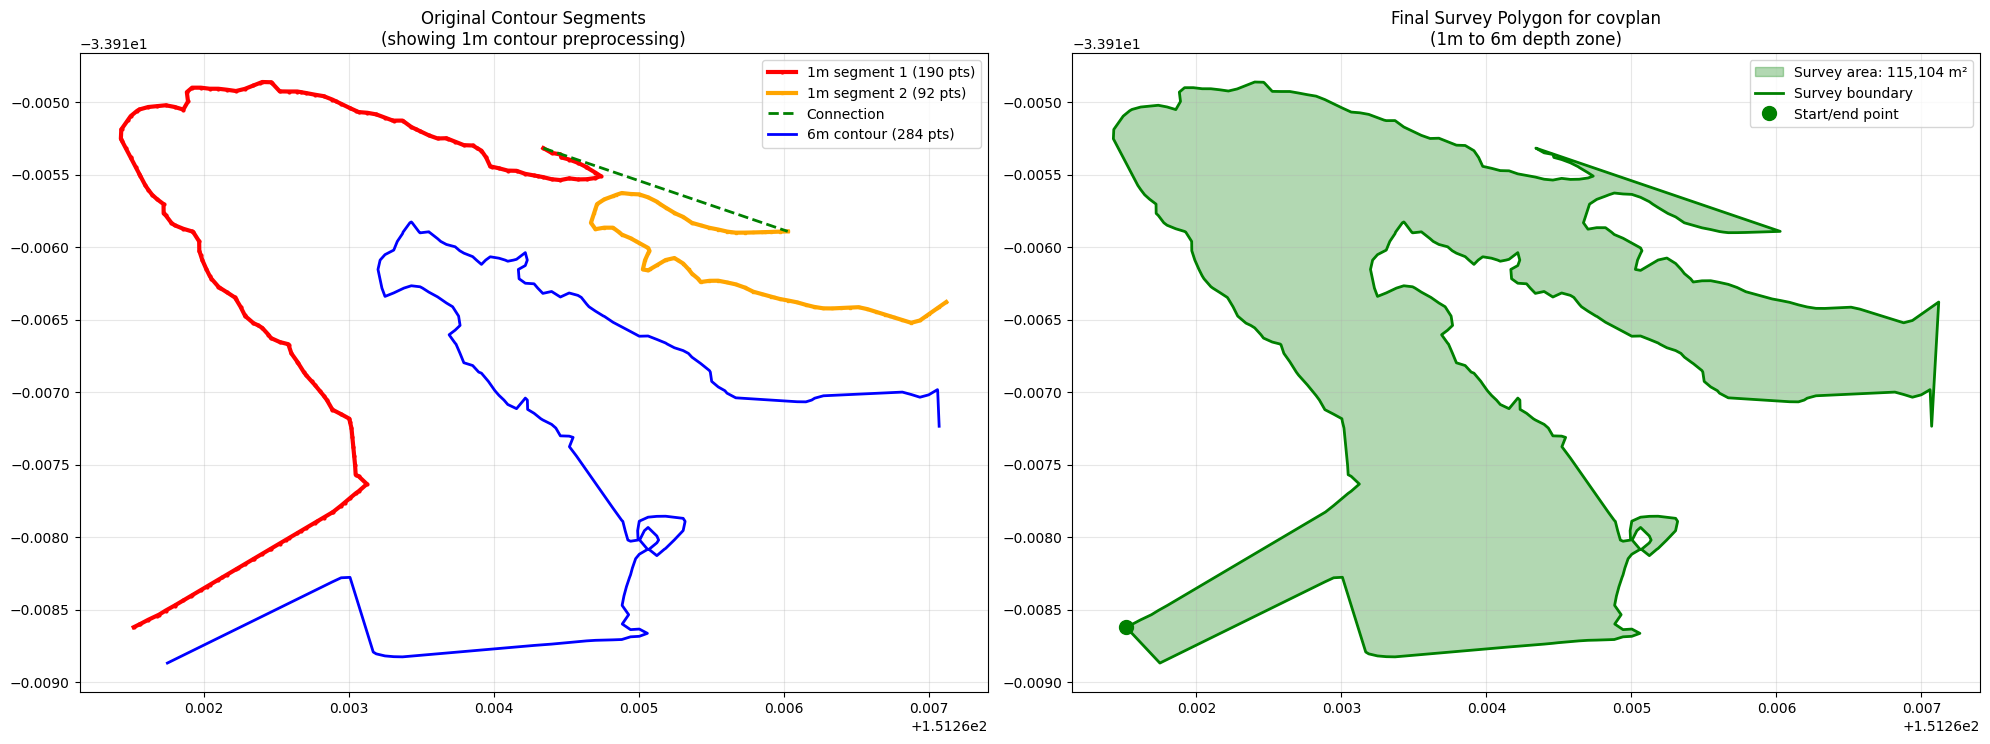

✅ Survey polygon ready for covplan!
   • Polygon area: 115,104 m²
   • Boundary points: 568
   • Depth range: 1m to 6m
   • Polygon valid: True

📋 Variables for covplan:
   • survey_polygon (Shapely Polygon object)
   • survey_boundary_coords (numpy array of [lon, lat] coordinates)


In [23]:
# Create survey polygon from 1m and 6m contours for planning the sweeps

# Extract contour line coordinates from the contour plot
if 'contours' in locals():
    # Extract coordinates for each contour level using allsegs
    contour_lines = {}
    for i, level in enumerate(contours.levels):
        level_segments = contours.allsegs[i]
        level_paths = [segment for segment in level_segments if len(segment) > 3]
        contour_lines[level] = level_paths
        print(f"  {level}m contour: {len(level_paths)} segments with lengths {[len(p) for p in level_paths]}")

    # Get the contour lines with preprocessing for broken 1m contour
    if -1 in contour_lines and -6 in contour_lines:
        
        # PREPROCESSING: Handle broken 1m contour by combining two longest segments
        segments_1m = sorted(contour_lines[-1], key=len, reverse=True)
        
        if len(segments_1m) >= 2:
            print(f"🔧 Preprocessing 1m contour: combining {len(segments_1m[0])} and {len(segments_1m[1])} point segments")
            
            # Get the two longest segments
            seg1 = np.array(segments_1m[0])
            seg2 = np.array(segments_1m[1])
            
            # Find the best way to connect them (shortest endpoint-to-endpoint distance)
            from scipy.spatial.distance import cdist
            
            # All possible endpoint combinations
            connections = [
                ('seg1_end', 'seg2_start', np.linalg.norm(seg1[-1] - seg2[0])),
                ('seg1_end', 'seg2_end', np.linalg.norm(seg1[-1] - seg2[-1])),
                ('seg1_start', 'seg2_start', np.linalg.norm(seg1[0] - seg2[0])),
                ('seg1_start', 'seg2_end', np.linalg.norm(seg1[0] - seg2[-1]))
            ]
            
            # Find shortest connection
            best_connection = min(connections, key=lambda x: x[2])
            print(f"   Best connection: {best_connection[0]} to {best_connection[1]} (distance: {best_connection[2]:.6f}°)")
            
            # Combine segments based on best connection
            if best_connection[0] == 'seg1_end' and best_connection[1] == 'seg2_start':
                contour_1m = np.vstack([seg1, seg2])
            elif best_connection[0] == 'seg1_end' and best_connection[1] == 'seg2_end':
                contour_1m = np.vstack([seg1, seg2[::-1]])
            elif best_connection[0] == 'seg1_start' and best_connection[1] == 'seg2_start':
                contour_1m = np.vstack([seg1[::-1], seg2])
            else:  # seg1_start to seg2_end
                contour_1m = np.vstack([seg1[::-1], seg2[::-1]])
            
            print(f"   Combined 1m contour: {len(contour_1m)} points total")
            
        else:
            # Fallback to single longest segment
            contour_1m = np.array(segments_1m[0])
            print(f"   Using single 1m contour segment: {len(contour_1m)} points")
        
        # Get the 6m contour (single longest segment)
        contour_6m = np.array(max(contour_lines[-6], key=len))
        print(f"   6m contour: {len(contour_6m)} points")
        
        # Find optimal endpoint connections between 1m and 6m contours
        from scipy.spatial.distance import cdist
        endpoints_1m = np.array([contour_1m[0], contour_1m[-1]])
        endpoints_6m = np.array([contour_6m[0], contour_6m[-1]])
        distances = cdist(endpoints_1m, endpoints_6m)
        min_idx = np.unravel_index(distances.argmin(), distances.shape)
        
        print(f"🔗 Optimal connection: 1m endpoint {min_idx[0]} to 6m endpoint {min_idx[1]} (distance: {distances[min_idx[0], min_idx[1]]:.6f}°)")
        
        # Orient contours for optimal closure
        oriented_1m = contour_1m if min_idx[0] == 0 else contour_1m[::-1]
        oriented_6m = contour_6m[::-1] if min_idx[1] == 0 else contour_6m
        
        # Create closed polygon with explicit connection lines
        survey_boundary_coords = np.vstack([
            oriented_1m,
            [oriented_6m[0]],     # Connection line
            oriented_6m,
            [oriented_1m[0]]      # Closing line
        ])
        
        # Create Shapely polygon for covplan
        from shapely.geometry import Polygon
        survey_polygon = Polygon(survey_boundary_coords)
        
        # Ensure polygon is valid
        if not survey_polygon.is_valid:
            survey_polygon = survey_polygon.buffer(0)
        
        # Visualize the final survey area with preprocessing details
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Left plot: Show the original segments and how they were combined
        if len(segments_1m) >= 2:
            seg1 = np.array(segments_1m[0])
            seg2 = np.array(segments_1m[1])
            axes[0].plot(seg1[:, 0], seg1[:, 1], 'r-', linewidth=3, label=f'1m segment 1 ({len(seg1)} pts)', marker='o', markersize=2)
            axes[0].plot(seg2[:, 0], seg2[:, 1], 'orange', linewidth=3, label=f'1m segment 2 ({len(seg2)} pts)', marker='s', markersize=2)
            # Show connection
            axes[0].plot([oriented_1m[len(seg1)-1, 0], oriented_1m[len(seg1), 0]], 
                        [oriented_1m[len(seg1)-1, 1], oriented_1m[len(seg1), 1]], 'g--', linewidth=2, label='Connection')
        
        axes[0].plot(contour_6m[:, 0], contour_6m[:, 1], 'b-', linewidth=2, label=f'6m contour ({len(contour_6m)} pts)')
        axes[0].set_title('Original Contour Segments\n(showing 1m contour preprocessing)')
        axes[0].legend()
        axes[0].set_aspect('equal')
        axes[0].grid(True, alpha=0.3)
        
        # Right plot: Final survey polygon
        axes[1].fill(survey_boundary_coords[:, 0], survey_boundary_coords[:, 1], 
                    alpha=0.3, color='green', label=f'Survey area: {survey_polygon.area * 111000**2:,.0f} m²')
        axes[1].plot(survey_boundary_coords[:, 0], survey_boundary_coords[:, 1], 
                    'g-', linewidth=2, label='Survey boundary')
        
        # Mark start point
        axes[1].plot(survey_boundary_coords[0, 0], survey_boundary_coords[0, 1], 
                    'go', markersize=10, label='Start/end point')
        
        axes[1].set_title('Final Survey Polygon for covplan\n(1m to 6m depth zone)')
        axes[1].legend()
        axes[1].set_aspect('equal')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary for covplan usage
        print(f"✅ Survey polygon ready for covplan!")
        print(f"   • Polygon area: {survey_polygon.area * 111000**2:,.0f} m²")
        print(f"   • Boundary points: {len(survey_boundary_coords)}")
        print(f"   • Depth range: 1m to 6m")
        print(f"   • Polygon valid: {survey_polygon.is_valid}")
        print(f"\n📋 Variables for covplan:")
        print(f"   • survey_polygon (Shapely Polygon object)")
        print(f"   • survey_boundary_coords (numpy array of [lon, lat] coordinates)")
        
    else:
        print("⚠️  Could not find 1m and 6m contour levels")
else:
    print("⚠️  Run the contour plotting cell first")

🗺️  LINE-BASED SCANNING OPTIMIZATION
🔍 LINE-BASED SCANNING PATH
   Creating 45° diagonal lines with 3m spacing
   Starting from: (151.265000, -33.915500)
   • Generated 407 line segments
   • Generated 407 line segments
   • Total path distance: 37650.5m
   • Path points: 814
   • Estimated scan time: 1255.0 minutes (20.9 hours)
   • Total path distance: 37650.5m
   • Path points: 814
   • Estimated scan time: 1255.0 minutes (20.9 hours)


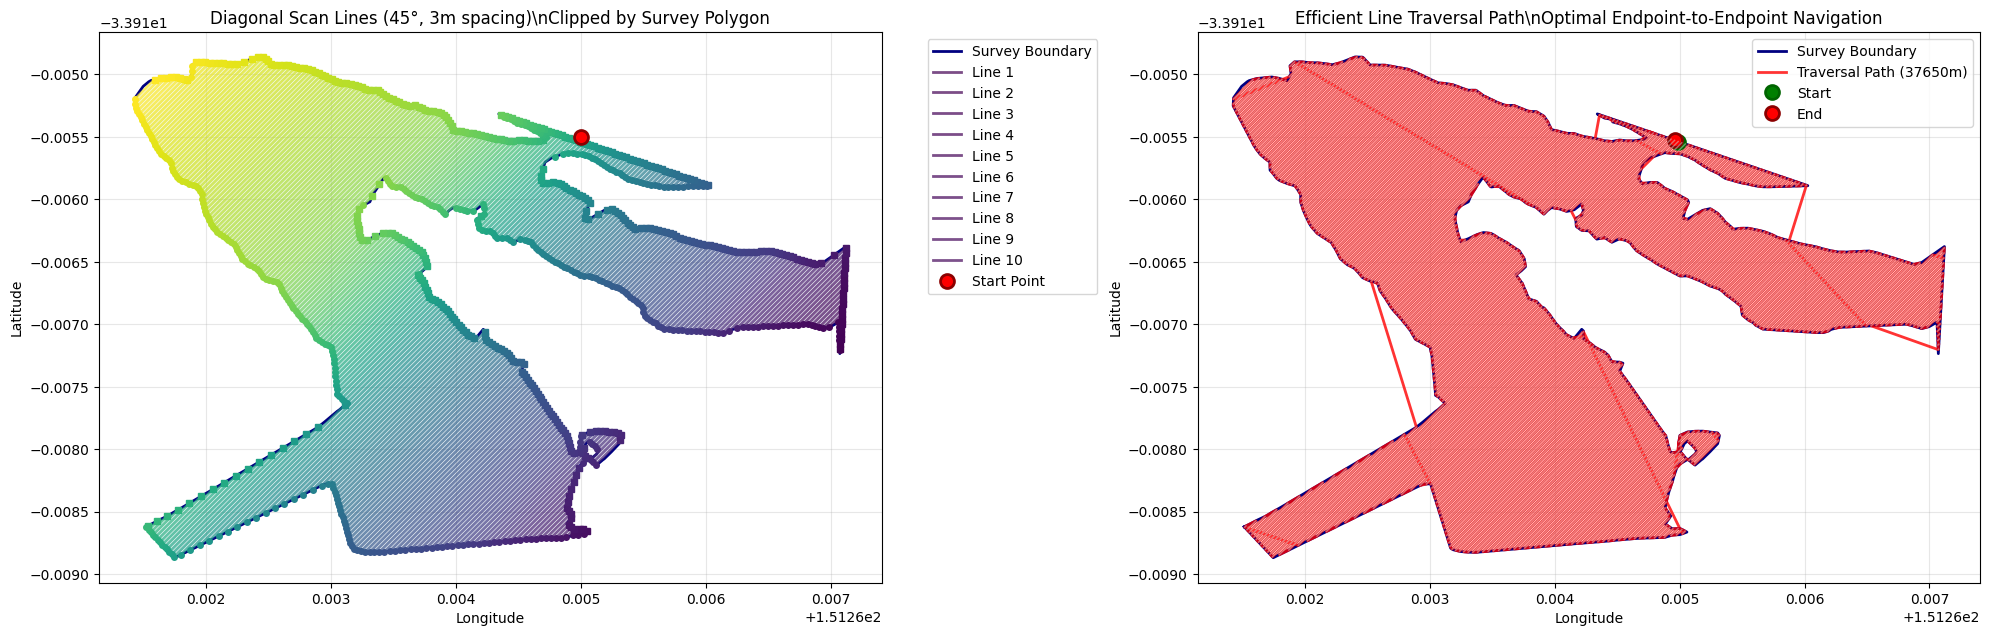


✅ Line-based scanning path created!
   • Method: 45° Diagonal Lines (3m spacing)
   • Line segments: 407
   • Total distance: 37650.5m
   • Scanning time: 1255.0 minutes
   • Stored as: line_scanning_path, line_scanning_segments


In [ ]:
# EFFICIENT LINE-BASED SCANNING PATH - 45 DEGREE APPROACH
# Create diagonal lines at 45° with 3m spacing, clipped by survey polygon


def create_diagonal_scan_lines(survey_polygon, spacing_m=3, angle_deg=45):
    """
    Create diagonal lines at specified angle and spacing, clipped by survey polygon.
    Returns list of line segments (as coordinate pairs).
    """
    from shapely.geometry import LineString
    from shapely.ops import split
    from shapely.affinity import rotate
    import math

    # Get polygon bounds
    minx, miny, maxx, maxy = survey_polygon.bounds

    # Convert spacing from meters to degrees
    spacing_deg = spacing_m / 111000  # 3m in degrees

    # Calculate diagonal extent to ensure we cover the entire area
    diagonal_length = math.sqrt((maxx - minx) ** 2 + (maxy - miny) ** 2)

    # Create parallel lines at specified angle
    angle_rad = math.radians(angle_deg)

    # Vector perpendicular to scan direction
    perp_x = -math.sin(angle_rad)
    perp_y = math.cos(angle_rad)

    # Vector along scan direction
    scan_x = math.cos(angle_rad)
    scan_y = math.sin(angle_rad)

    # Find center point
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # Create lines extending well beyond the polygon
    extension = diagonal_length * 2
    scan_lines = []

    # Calculate how many lines we need
    perp_extent = abs(perp_x * (maxx - minx)) + abs(perp_y * (maxy - miny))
    num_lines = int(perp_extent / spacing_deg) + 2

    for i in range(-num_lines // 2, num_lines // 2 + 1):
        # Offset from center line
        offset = i * spacing_deg

        # Line center point
        line_center_x = center_x + perp_x * offset
        line_center_y = center_y + perp_y * offset

        # Line endpoints (extended beyond polygon)
        start_x = line_center_x - scan_x * extension
        start_y = line_center_y - scan_y * extension
        end_x = line_center_x + scan_x * extension
        end_y = line_center_y + scan_y * extension

        line = LineString([(start_x, start_y), (end_x, end_y)])
        scan_lines.append(line)

    # Clip lines with survey polygon and extract segments
    clipped_segments = []
    for line in scan_lines:
        try:
            intersection = line.intersection(survey_polygon)

            # Handle different intersection types
            if intersection.geom_type == "LineString":
                if len(intersection.coords) >= 2:
                    clipped_segments.append(list(intersection.coords))
            elif intersection.geom_type == "MultiLineString":
                for segment in intersection.geoms:
                    if len(segment.coords) >= 2:
                        clipped_segments.append(list(segment.coords))
        except:
            continue  # Skip problematic intersections

    return clipped_segments


def create_line_traversal_path(line_segments, start_point):
    """
    Create efficient traversal path through line segments.
    Strategy: Start at nearest endpoint, traverse line, find nearest next endpoint, repeat.
    """
    if not line_segments:
        return [], 0

    # Extract all endpoints
    endpoints = []
    for i, segment in enumerate(line_segments):
        endpoints.append((i, 0, segment[0]))  # (segment_idx, end_idx, coordinates)
        endpoints.append((i, 1, segment[-1]))  # (segment_idx, end_idx, coordinates)

    # Find closest endpoint to start point
    start_array = np.array(start_point)
    distances = [np.linalg.norm(np.array(ep[2]) - start_array) for ep in endpoints]
    current_endpoint_idx = np.argmin(distances)

    path = []
    used_segments = set()

    while len(used_segments) < len(line_segments):
        # Get current endpoint
        seg_idx, end_idx, coords = endpoints[current_endpoint_idx]

        if seg_idx in used_segments:
            # Find nearest unused endpoint
            available_endpoints = [
                i for i, ep in enumerate(endpoints) if ep[0] not in used_segments
            ]
            if not available_endpoints:
                break

            current_pos = path[-1] if path else start_point
            distances = [
                np.linalg.norm(np.array(endpoints[i][2]) - np.array(current_pos))
                for i in available_endpoints
            ]
            nearest_idx = available_endpoints[np.argmin(distances)]
            current_endpoint_idx = nearest_idx
            seg_idx, end_idx, coords = endpoints[current_endpoint_idx]

        # Add this segment to path
        segment = line_segments[seg_idx]
        if end_idx == 0:
            # Start from beginning of segment
            path.extend(segment)
        else:
            # Start from end of segment (reverse direction)
            path.extend(segment[::-1])

        used_segments.add(seg_idx)

        # Find nearest available endpoint for next segment
        if len(used_segments) < len(line_segments):
            available_endpoints = [
                i for i, ep in enumerate(endpoints) if ep[0] not in used_segments
            ]
            if available_endpoints:
                current_pos = path[-1]
                distances = [
                    np.linalg.norm(np.array(endpoints[i][2]) - np.array(current_pos))
                    for i in available_endpoints
                ]
                current_endpoint_idx = available_endpoints[np.argmin(distances)]

    # Calculate total distance
    total_distance = 0
    if len(path) > 1:
        for i in range(len(path) - 1):
            p1 = (path[i][1], path[i][0])  # lat, lon
            p2 = (path[i + 1][1], path[i + 1][0])  # lat, lon
            total_distance += geodesic(p1, p2).meters

    return path, total_distance


def visualize_line_based_scanning(survey_polygon, start_point):
    """Visualize the line-based scanning approach"""

    # Convert start point (accounting for axis offset)
    start_lon = 1.5126e2 + start_point[0]
    start_lat = -3.391e1 + start_point[1]
    custom_start = [start_lon, start_lat]

    print(f"🔍 LINE-BASED SCANNING PATH")
    print(f"   Creating 45° diagonal lines with 3m spacing")
    print(f"   Starting from: ({start_lon:.6f}, {start_lat:.6f})")
    print("=" * 60)

    # Create scan lines
    try:
        line_segments = create_diagonal_scan_lines(
            survey_polygon, spacing_m=3, angle_deg=45
        )
        print(f"   • Generated {len(line_segments)} line segments")

        # Create traversal path
        path, total_distance = create_line_traversal_path(line_segments, custom_start)
        print(f"   • Total path distance: {total_distance:.1f}m")
        print(f"   • Path points: {len(path)}")

        # Estimate scanning time (2 m/s surface speed)
        swim_speed = 2  # km/h
        scan_time_minutes = total_distance / 60 * swim_speed  # in minutes
        print(
            f"   • Estimated scan time: {scan_time_minutes:.1f} minutes ({scan_time_minutes/60:.1f} hours)"
        )

    except Exception as e:
        print(f"   ⚠️  Error creating scan lines: {e}")
        return None

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Left plot: Show scan lines and clipped segments
    if survey_polygon and hasattr(survey_polygon, "exterior"):
        x_poly, y_poly = survey_polygon.exterior.xy
        ax1.plot(x_poly, y_poly, "navy", linewidth=2, label="Survey Boundary")
        ax1.fill(x_poly, y_poly, alpha=0.1, color="lightblue")

    # Plot all line segments in different colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(line_segments)))
    for i, (segment, color) in enumerate(zip(line_segments, colors)):
        if len(segment) >= 2:
            seg_array = np.array(segment)
            ax1.plot(
                seg_array[:, 0],
                seg_array[:, 1],
                color=color,
                linewidth=2,
                alpha=0.7,
                label=f"Line {i+1}" if i < 10 else "",
            )
            # Mark endpoints
            ax1.plot(segment[0][0], segment[0][1], "o", color=color, markersize=4)
            ax1.plot(segment[-1][0], segment[-1][1], "s", color=color, markersize=4)

    # Mark start point
    ax1.plot(
        custom_start[0],
        custom_start[1],
        "ro",
        markersize=10,
        markeredgecolor="darkred",
        markeredgewidth=2,
        label="Start Point",
    )

    ax1.set_title("Diagonal Scan Lines (45°, 3m spacing)\nClipped by Survey Polygon")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect("equal")

    # Right plot: Show traversal path
    if survey_polygon and hasattr(survey_polygon, "exterior"):
        x_poly, y_poly = survey_polygon.exterior.xy
        ax2.plot(x_poly, y_poly, "navy", linewidth=2, label="Survey Boundary")
        ax2.fill(x_poly, y_poly, alpha=0.1, color="lightblue")

    if len(path) > 1:
        path_array = np.array(path)
        ax2.plot(
            path_array[:, 0],
            path_array[:, 1],
            "red",
            linewidth=2,
            alpha=0.8,
            label=f"Traversal Path ({total_distance:.0f}m)",
        )

        # Mark start and end
        ax2.plot(
            path[0][0],
            path[0][1],
            "go",
            markersize=10,
            markeredgecolor="darkgreen",
            markeredgewidth=2,
            label="Start",
        )
        ax2.plot(
            path[-1][0],
            path[-1][1],
            "ro",
            markersize=10,
            markeredgecolor="darkred",
            markeredgewidth=2,
            label="End",
        )

        # Show line segments as background
        for segment in line_segments:
            if len(segment) >= 2:
                seg_array = np.array(segment)
                ax2.plot(
                    seg_array[:, 0],
                    seg_array[:, 1],
                    "lightgray",
                    linewidth=1,
                    alpha=0.5,
                )

    ax2.set_title(
        "Efficient Line Traversal Path\nOptimal Endpoint-to-Endpoint Navigation"
    )
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect("equal")

    plt.tight_layout()
    plt.show()

    return {
        "line_segments": line_segments,
        "path": path,
        "total_distance": total_distance,
        "scan_time_minutes": scan_time_minutes,
        "start_point": custom_start,
    }


# Run the line-based scanning optimization
if "survey_polygon" in globals():
    print("🗺️  LINE-BASED SCANNING OPTIMIZATION")
    print("=" * 60)

    # Use custom start point
    custom_start_point = [0.005, -0.0055]

    line_result = visualize_line_based_scanning(survey_polygon, custom_start_point)

    if line_result:
        # Store results
        globals()["line_scanning_segments"] = line_result["line_segments"]
        globals()["line_scanning_path"] = line_result["path"]
        globals()["line_scanning_distance"] = line_result["total_distance"]
        globals()["line_scanning_time"] = line_result["scan_time_minutes"]

        print(f"\n✅ Line-based scanning path created!")
        print(f"   • Method: 45° Diagonal Lines (3m spacing)")
        print(f"   • Line segments: {len(line_result['line_segments'])}")
        print(f"   • Total distance: {line_result['total_distance']:.1f}m")
        print(f"   • Scanning time: {line_result['scan_time_minutes']:.1f} minutes")
        print(f"   • Stored as: line_scanning_path, line_scanning_segments")


else:
    print("⚠️  No survey_polygon found. Run cell 34 first.")

🗺️  STAR PATTERN LINE-BASED SCANNING
🌟 STAR PATTERN LINE-BASED SCANNING
   Line spacing: 3m
   Angle: 45 degrees
   Base point: (151.265000, -33.915500)
   • Generated 407 transect line segments
   • Generated 407 transect line segments
   • Created 39 scanning sessions
   • Total distance: 53044.5m
   • Estimated time: 1768.1 minutes (29.5 hours)
   • Session 1: 1486m, ~50 min, 46 lines
   • Session 2: 1412m, ~47 min, 22 lines
   • Session 3: 1464m, ~49 min, 32 lines
   • Session 4: 1291m, ~43 min, 14 lines
   • Session 5: 1434m, ~48 min, 20 lines
   • Session 6: 1482m, ~49 min, 15 lines
   • Session 7: 1484m, ~49 min, 13 lines
   • Session 8: 1393m, ~46 min, 6 lines
   • Session 9: 1381m, ~46 min, 6 lines
   • Session 10: 1360m, ~45 min, 6 lines
   • Session 11: 1411m, ~47 min, 10 lines
   • Session 12: 1421m, ~47 min, 11 lines
   • Session 13: 1353m, ~45 min, 6 lines
   • Session 14: 1281m, ~43 min, 8 lines
   • Session 15: 1461m, ~49 min, 12 lines
   • Session 16: 1465m, ~49 min, 6

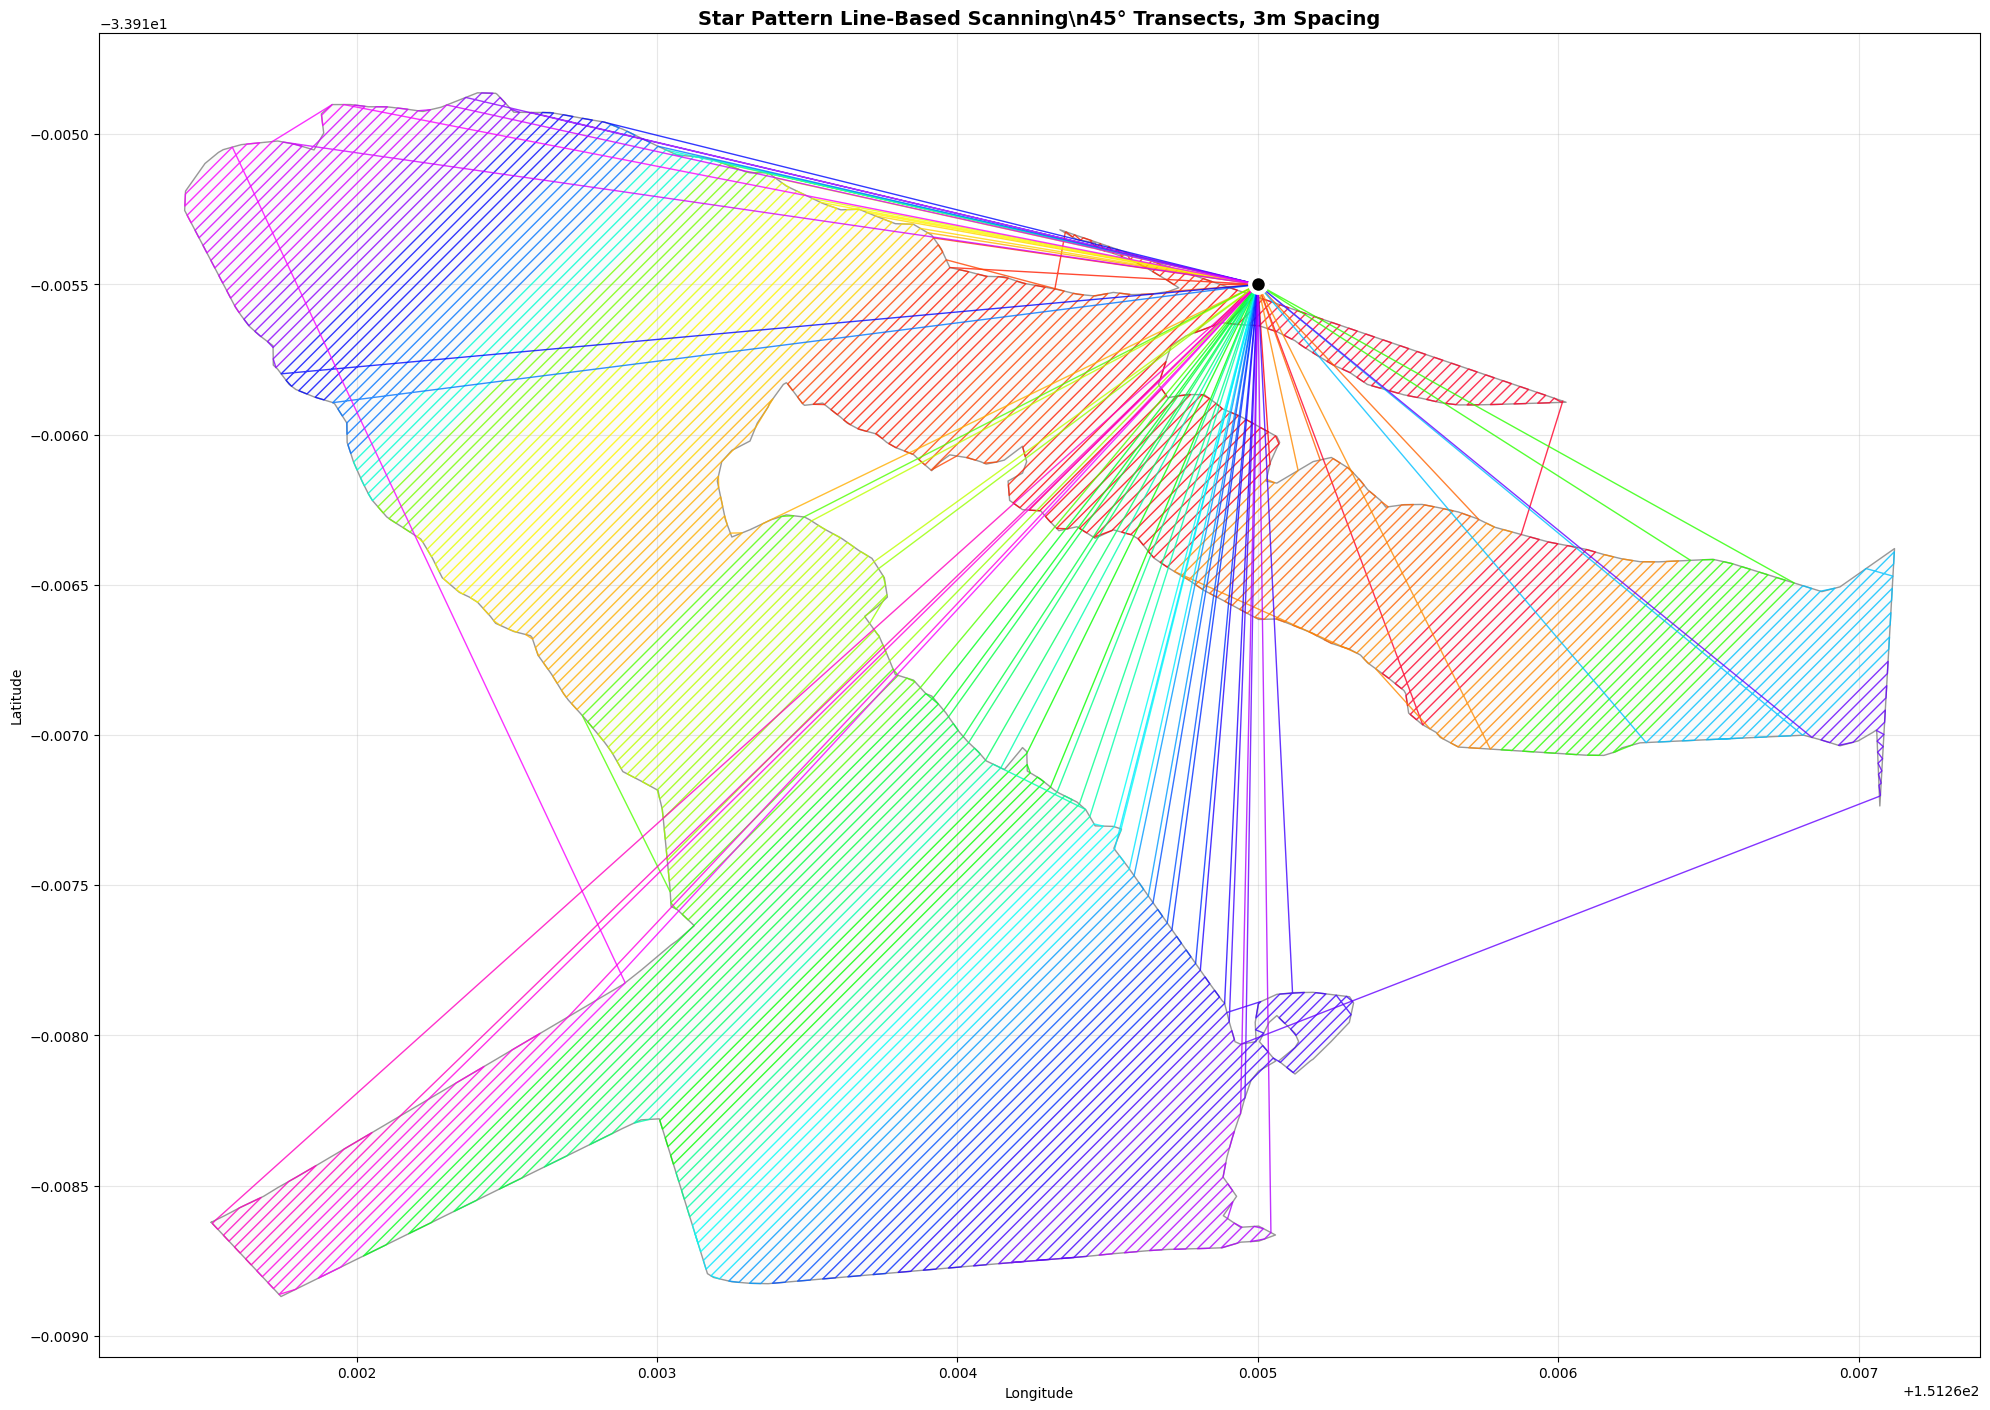

\n✅ Star pattern scanning plan created!


In [ ]:
# LINE-BASED SURFACE SCANNING - STAR PATTERN WITH 1KM SEGMENTS
# Create 45-degree transect lines, then organize into 1km segments that each start from base point

def create_transect_lines(survey_polygon, start_point, line_spacing_m=3, angle_deg=45):
    """
    Create parallel transect lines at specified angle and spacing.
    Lines are trimmed by the survey polygon.
    """
    from shapely.geometry import LineString
    from shapely.affinity import rotate
    import math
    
    # Get survey bounds
    minx, miny, maxx, maxy = survey_polygon.bounds
    
    # Convert spacing to degrees
    line_spacing_deg = line_spacing_m / 111000
    
    # Create a large bounding box to ensure lines cover the survey area
    buffer = max(maxx - minx, maxy - miny)
    center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
    
    # Calculate perpendicular direction to create parallel lines
    angle_rad = math.radians(angle_deg)
    perp_angle_rad = angle_rad + math.pi / 2
    
    # Calculate line extent (make it large enough to cover survey area)
    line_length = buffer * 2
    dx = line_length * math.cos(angle_rad)
    dy = line_length * math.sin(angle_rad)
    
    # Calculate perpendicular offset for each line
    perp_dx = line_spacing_deg * math.cos(perp_angle_rad)
    perp_dy = line_spacing_deg * math.sin(perp_angle_rad)
    
    # Create parallel lines
    lines = []
    num_lines = int(buffer / line_spacing_deg) * 2 + 10  # Extra lines to ensure coverage
    
    for i in range(-num_lines//2, num_lines//2):
        # Start point for this line
        start_x = center_x + i * perp_dx - dx/2
        start_y = center_y + i * perp_dy - dy/2
        
        # End point for this line
        end_x = start_x + dx
        end_y = start_y + dy
        
        # Create line
        line = LineString([(start_x, start_y), (end_x, end_y)])
        
        # Trim line with survey polygon
        intersection = survey_polygon.intersection(line)
        
        if intersection.geom_type == 'LineString' and not intersection.is_empty:
            lines.append(intersection)
        elif intersection.geom_type == 'MultiLineString':
            # Add all line segments
            for geom in intersection.geoms:
                if not geom.is_empty:
                    lines.append(geom)
    
    return lines

def organize_lines_into_star_segments(lines, start_point, max_segment_distance_m=1000):
    """
    Organize lines into segments where each segment starts from start_point,
    travels along lines, and returns to start_point within max_segment_distance_m.
    """
    if not lines:
        return []
    
    # Convert lines to start/end points with line references
    line_segments = []
    for i, line in enumerate(lines):
        coords = list(line.coords)
        start_pt = np.array(coords[0])
        end_pt = np.array(coords[-1])
        line_segments.append({
            'line_id': i,
            'start': start_pt,
            'end': end_pt,
            'coords': coords,
            'used': False
        })
    
    start_array = np.array(start_point)
    segments = []
    segment_id = 0
    
    while any(not seg['used'] for seg in line_segments):
        # Start new segment from start_point
        current_segment = {
            'segment_id': segment_id,
            'path': [start_point],  # Always start from base point
            'distance': 0,
            'lines_used': []
        }
        
        current_pos = start_array
        
        # Find unused line segments and organize them for this segment
        while current_segment['distance'] < max_segment_distance_m:
            # Find nearest unused line endpoint
            unused_segments = [seg for seg in line_segments if not seg['used']]
            if not unused_segments:
                break
            
            # Calculate distances to all unused line endpoints
            distances_to_starts = []
            distances_to_ends = []
            
            for seg in unused_segments:
                dist_to_start = np.linalg.norm(seg['start'] - current_pos)
                dist_to_end = np.linalg.norm(seg['end'] - current_pos)
                distances_to_starts.append(dist_to_start)
                distances_to_ends.append(dist_to_end)
            
            # Find closest endpoint
            min_start_idx = np.argmin(distances_to_starts)
            min_end_idx = np.argmin(distances_to_ends)
            
            min_start_dist = distances_to_starts[min_start_idx]
            min_end_dist = distances_to_ends[min_end_idx]
            
            if min_start_dist < min_end_dist:
                # Go to start, traverse to end
                chosen_seg = unused_segments[min_start_idx]
                entry_point = chosen_seg['start']
                exit_point = chosen_seg['end']
                traverse_coords = chosen_seg['coords']
            else:
                # Go to end, traverse to start
                chosen_seg = unused_segments[min_end_idx]
                entry_point = chosen_seg['end']
                exit_point = chosen_seg['start']
                traverse_coords = chosen_seg['coords'][::-1]  # Reverse direction
            
            # Calculate distances
            approach_dist = geodesic((current_pos[1], current_pos[0]), 
                                   (entry_point[1], entry_point[0])).meters
            
            traverse_dist = 0
            for j in range(len(traverse_coords) - 1):
                p1 = traverse_coords[j]
                p2 = traverse_coords[j + 1]
                traverse_dist += geodesic((p1[1], p1[0]), (p2[1], p2[0])).meters
            
            return_dist = geodesic((exit_point[1], exit_point[0]), 
                                 (start_point[1], start_point[0])).meters
            
            total_addition = approach_dist + traverse_dist + return_dist
            
            # Check if this line fits in current segment
            if current_segment['distance'] + total_addition > max_segment_distance_m:
                break
            
            # Add this line to current segment
            current_segment['path'].extend(traverse_coords)
            current_segment['distance'] += approach_dist + traverse_dist
            current_segment['lines_used'].append(chosen_seg['line_id'])
            
            # Mark as used
            chosen_seg['used'] = True
            current_pos = exit_point
        
        # Complete segment by returning to start point
        return_distance = geodesic((current_pos[1], current_pos[0]), 
                                 (start_point[1], start_point[0])).meters
        current_segment['path'].append(start_point)
        current_segment['distance'] += return_distance
        
        if len(current_segment['lines_used']) > 0:  # Only add segments with actual lines
            segments.append(current_segment)
            segment_id += 1
    
    return segments

def visualize_star_pattern_scanning(survey_polygon, start_point, line_spacing_m=3):
    """Visualize the star-pattern line-based scanning approach"""
    
    print(f"🌟 STAR PATTERN LINE-BASED SCANNING")
    print(f"   Line spacing: {line_spacing_m}m")
    print(f"   Angle: 45 degrees")
    print("=" * 60)
    
    # Convert start point from axis notation
    start_lon = 1.5126e2 + start_point[0]
    start_lat = -3.391e1 + start_point[1]
    custom_start = [start_lon, start_lat]
    
    print(f"   Base point: ({start_lon:.6f}, {start_lat:.6f})")
    
    try:
        # Create transect lines
        lines = create_transect_lines(survey_polygon, custom_start, line_spacing_m, 45)
        print(f"   • Generated {len(lines)} transect line segments")
        
        # Organize into star-pattern segments
        star_segments = organize_lines_into_star_segments(lines, custom_start, 1500)
        print(f"   • Created {len(star_segments)} scanning sessions")
        
        # Calculate totals
        total_distance = sum(seg['distance'] for seg in star_segments)
        swim_speed  =2 #km/h
        total_scan_time = total_distance / 60 * swim_speed  # in minutes
        
        print(f"   • Total distance: {total_distance:.1f}m")
        print(f"   • Estimated time: {total_scan_time:.1f} minutes ({total_scan_time/60:.1f} hours)")
        
        # Session details
        for i, segment in enumerate(star_segments):
            session_time = segment['distance'] / 60 * swim_speed
            print(f"   • Session {i+1}: {segment['distance']:.0f}m, ~{session_time:.0f} min, {len(segment['lines_used'])} lines")
            
    except Exception as e:
        print(f"   ⚠️  Line generation failed: {e}")
        return None
    
    # Create visualization
    fig, ax1 = plt.subplots(figsize=(20, 20))
    
    # Left plot: Show all transect lines and star segments
    if survey_polygon and hasattr(survey_polygon, 'exterior'):
        x_poly, y_poly = survey_polygon.exterior.xy
        ax1.plot(x_poly, y_poly, 'gray', linewidth=1, alpha=0.8, label='Survey Boundary')
        ax1.fill(x_poly, y_poly, alpha=0.1, color='lightgray')
    
    # Plot star segments in different colors
    colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(star_segments)))

    for i, (segment, color) in enumerate(zip(star_segments, colors)):
        if len(segment['path']) > 1:
            path_array = np.array(segment['path'])
            ax1.plot(path_array[:, 0], path_array[:, 1], 
                    color=color, linewidth=1, alpha=0.8, zorder=3,
                    label=f'Session {i+1} ({segment["distance"]:.0f}m)')
    
    # Mark base point
    ax1.plot(custom_start[0], custom_start[1], 'ko', markersize=12, 
            markeredgecolor='white', markeredgewidth=3,
            label='Base Point', zorder=5)
    
    ax1.set_title('Star Pattern Line-Based Scanning\n45° Transects, 3m Spacing', 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
            
    plt.tight_layout()
    plt.show()
    
    return {
        'transect_lines': lines,
        'star_segments': star_segments,
        'total_distance': total_distance,
        'scan_time_minutes': total_scan_time,
        'base_point': custom_start
    }

# Run the star pattern line-based scanning
if 'survey_polygon' in globals():
    print("🗺️  STAR PATTERN LINE-BASED SCANNING")
    print("=" * 60)
    
    # Define custom start point (from axes notation)
    custom_start_point = [0.005, -0.0055]
    
    star_result = visualize_star_pattern_scanning(survey_polygon, custom_start_point, 3)
    
    if star_result:
        # Store results
        globals()['star_pattern_lines'] = star_result['transect_lines']
        globals()['star_pattern_segments'] = star_result['star_segments']
        globals()['star_pattern_distance'] = star_result['total_distance']
        globals()['star_pattern_time'] = star_result['scan_time_minutes']
        globals()['star_base_point'] = star_result['base_point']
        
        print(f"\\n✅ Star pattern scanning plan created!")
        
            
else:
    print("⚠️  No survey_polygon found. Run the contour extraction cells first.")